<a href="https://colab.research.google.com/github/marikaitiprim/AreaPolygonization-Project/blob/main/MusicGenreClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Q1: Feedforward Neural Network**

 ***Step 1: Load Data (mfccs)***

In [ ]:
import os
import glob
from google.colab import drive
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader

#load files as arrays
train_mfccs_X = np.load("/content/drive/MyDrive/music_genre_data_di/train/mfccs/X.npy")
train_mfccs_labels = np.load("/content/drive/MyDrive/music_genre_data_di/train/mfccs/labels.npy")
test_mfccs_X = np.load("/content/drive/MyDrive/music_genre_data_di/test/mfccs/X.npy")
test_mfccs_labels = np.load("/content/drive/MyDrive/music_genre_data_di/test/mfccs/labels.npy")
val_mfccs_X = np.load("/content/drive/MyDrive/music_genre_data_di/val/mfccs/X.npy")
val_mfccs_labels = np.load("/content/drive/MyDrive/music_genre_data_di/val/mfccs/labels.npy")

#give a number to each category
categories = ["classical","hiphop","rock_metal_hardrock","blues"]
num_categories = dict(zip(categories,range(0,4)))

#for test set
testlabels = (pd.Series(test_mfccs_labels)).map(num_categories)
testlabels = list(testlabels)
test_data = list(zip(test_mfccs_X,testlabels))

#for train set
trainlabels = (pd.Series(train_mfccs_labels)).map(num_categories)
trainlabels = list(trainlabels)
train_data = list(zip(train_mfccs_X,trainlabels))

#for val set
vallabels = (pd.Series(val_mfccs_labels)).map(num_categories)
vallabels = list(vallabels)
val_data = list(zip(val_mfccs_X,vallabels))

#Dataloaders
train_dataloader = DataLoader(train_data,batch_size = 16, shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=16,shuffle=False)
val_dataloader = DataLoader(val_data,batch_size=16,shuffle=True)

***Step 2: Define Neural Network***

In [ ]:
import torch
import torch.nn as nn

class FNN(nn.Module):
  def __init__(self, input_dim=26, hidden_dim1=128,hidden_dim2=32, output_dim=4):
    super(FNN, self).__init__()
    # Linear function 1: 26 --> 128
    self.fc1 = nn.Linear(input_dim, hidden_dim1)

    # Linear function 2: 128 --> 32
    self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)

    # Linear function 3: 32 --> 4
    self.fc3 = nn.Linear(hidden_dim2, output_dim)

  def forward(self, x):
    # Linear function 1
    out = self.fc1(x)

    # Linear function 2
    out = self.fc2(out)

    # Linear function 3 (readout)
    out = self.fc3(out)

    return out

***Step 3: Define training procedure***

In [ ]:
def trainFNN(num_epochs,optimizer,dataloader,lossfun,fnn):
  size = len(dataloader.dataset)
  for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}\n------------------")
    for i, (X, labels) in enumerate(dataloader):
      X = X.type(torch.FloatTensor)
      output = fnn(X)
      loss = lossfun(output, labels)

      # backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if i%10 == 0:
        loss,current = loss.item(), i*len(X)
        print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    print("\n")
  return fnn

***Step 4: Define evaluation procedure***

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

def testFNN(dataloader,lossfun,fnn):
  correct = 0
  total = 0
  test_loss = 0
  size = len(dataloader.dataset)
  y_true = []
  y_pred = []

  # Iterate through test dataset
  with torch.no_grad():
    for X, labels in dataloader:
      X = X.type(torch.float)
      output = fnn(X)
      test_loss += lossfun(output, labels).item()
      correct += (output.argmax(1)==labels).type(torch.float).sum().item()
      y_true.append(labels)
      y_pred.append(output.argmax(1))

  y_true = torch.cat(y_true)
  y_pred = torch.cat(y_pred)
  correct /= size
  accuracy = 100*correct
  test_loss /= size
  f1 = f1_score(y_true,y_pred,average='macro')
  cm = confusion_matrix(y_true,y_pred)
  return test_loss,f1,accuracy,cm

***Step 5: Network training***

In [ ]:
import time

num_epochs = 30
lossfun = nn.CrossEntropyLoss()
learning_rate = 0.002
fnn_model_cpu = FNN()
optimizer = torch.optim.SGD(fnn_model_cpu.parameters(), lr=learning_rate)

#train
start_train_cpu_time = time.time()
fnn_model_cpu = trainFNN(num_epochs,optimizer,train_dataloader,lossfun,fnn_model_cpu)
train_cpu_time = time.time() - start_train_cpu_time

Epoch: 1
------------------
loss: 1.244753 [    0/ 3200]
loss: 1.358246 [  160/ 3200]
loss: 1.419749 [  320/ 3200]
loss: 1.354711 [  480/ 3200]
loss: 1.392903 [  640/ 3200]
loss: 1.383587 [  800/ 3200]
loss: 1.359425 [  960/ 3200]
loss: 1.422691 [ 1120/ 3200]
loss: 1.332255 [ 1280/ 3200]
loss: 1.404573 [ 1440/ 3200]
loss: 1.378997 [ 1600/ 3200]
loss: 1.391558 [ 1760/ 3200]
loss: 1.330912 [ 1920/ 3200]
loss: 1.431878 [ 2080/ 3200]
loss: 1.328807 [ 2240/ 3200]
loss: 1.430459 [ 2400/ 3200]
loss: 1.345749 [ 2560/ 3200]
loss: 1.369426 [ 2720/ 3200]
loss: 1.281264 [ 2880/ 3200]
loss: 1.378105 [ 3040/ 3200]


Epoch: 2
------------------
loss: 1.332696 [    0/ 3200]
loss: 1.314952 [  160/ 3200]
loss: 1.411778 [  320/ 3200]
loss: 1.358252 [  480/ 3200]
loss: 1.352906 [  640/ 3200]
loss: 1.344516 [  800/ 3200]
loss: 1.308321 [  960/ 3200]
loss: 1.356390 [ 1120/ 3200]
loss: 1.334760 [ 1280/ 3200]
loss: 1.313471 [ 1440/ 3200]
loss: 1.366642 [ 1600/ 3200]
loss: 1.356893 [ 1760/ 3200]
loss: 1.350443

In [ ]:
#test
start_test_cpu_time = time.time()
loss,f1,accuracy,cm = testFNN(test_dataloader,lossfun,fnn_model_cpu)
test_cpu_time = time.time() - start_test_cpu_time
print(f"Loss: {loss:>8f}\nAccuracy: {accuracy:>0.1f}%\nF1 macro averaged: {f1:>8f}\nConfusion matrix: {cm}")

Loss: 0.062031
Accuracy: 60.3%
F1 macro averaged: 0.604463
Confusion matrix: [[187  15  14  81]
 [  7 286  11  52]
 [ 14  59 235  91]
 [  9 115  78 122]]


***Step 6: Network training with GPU***

In [ ]:
def trainFNN_GPU(num_epochs,optimizer,dataloader,lossfun,fnn):
  size = len(dataloader.dataset)
  for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}\n------------------")
    for i, (X, labels) in enumerate(dataloader):
        X = X.type(torch.FloatTensor)

        #gpu
        X = X.to(device)
        labels = labels.to(device)

        output = fnn(X)
        loss = lossfun(output, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i%10 == 0:
          loss,current = loss.item(), i*len(X)
          print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    print("\n")
  return fnn

In [ ]:
def testFNN_GPU(dataloader,lossfun,fnn):
  correct = 0
  total = 0
  test_loss = 0
  size = len(dataloader.dataset)
  y_true = []
  y_pred = []

  # Iterate through test dataset
  with torch.no_grad():
    for X, labels in dataloader:
      X = X.type(torch.float)

      #gpu
      X = X.to(device)
      labels = labels.to(device)

      output = fnn(X)
      test_loss += lossfun(output, labels).item()
      correct += (output.argmax(1)==labels).type(torch.float).sum().item()
      y_true.append(labels)
      y_pred.append(output.argmax(1))

  y_true = torch.cat(y_true)
  y_pred = torch.cat(y_pred)

  correct /= size
  accuracy = 100*correct
  test_loss /= size

  y_true = y_true.cpu()
  y_pred = y_pred.cpu()

  f1 = f1_score(y_true,y_pred,average='macro')
  cm = confusion_matrix(y_true,y_pred)
  return test_loss,f1,accuracy,cm

In [ ]:
device = 'cuda'
num_epochs = 30
lossfun = nn.CrossEntropyLoss()
learning_rate = 0.002

#load model to gpu
fnn_model_gpu = FNN().to(device)

optimizer = torch.optim.SGD(fnn_model_gpu.parameters(), lr=learning_rate)

#train
start_train_gpu_time = time.time()
fnn_model_gpu = trainFNN_GPU(num_epochs,optimizer,train_dataloader,lossfun,fnn_model_gpu)
train_gpu_time = time.time() - start_train_gpu_time

Epoch: 1
------------------
loss: 2.193876 [    0/ 3200]
loss: 1.464325 [  160/ 3200]
loss: 1.402948 [  320/ 3200]
loss: 1.469823 [  480/ 3200]
loss: 1.381014 [  640/ 3200]
loss: 1.412704 [  800/ 3200]
loss: 1.405490 [  960/ 3200]
loss: 1.403006 [ 1120/ 3200]
loss: 1.435978 [ 1280/ 3200]
loss: 1.347246 [ 1440/ 3200]
loss: 1.510694 [ 1600/ 3200]
loss: 1.429876 [ 1760/ 3200]
loss: 1.397493 [ 1920/ 3200]
loss: 1.457436 [ 2080/ 3200]
loss: 1.350357 [ 2240/ 3200]
loss: 1.390645 [ 2400/ 3200]
loss: 1.405657 [ 2560/ 3200]
loss: 1.319173 [ 2720/ 3200]
loss: 1.405421 [ 2880/ 3200]
loss: 1.437520 [ 3040/ 3200]


Epoch: 2
------------------
loss: 1.393511 [    0/ 3200]
loss: 1.399652 [  160/ 3200]
loss: 1.422883 [  320/ 3200]
loss: 1.393435 [  480/ 3200]
loss: 1.366210 [  640/ 3200]
loss: 1.519250 [  800/ 3200]
loss: 1.435773 [  960/ 3200]
loss: 1.347331 [ 1120/ 3200]
loss: 1.397486 [ 1280/ 3200]
loss: 1.359713 [ 1440/ 3200]
loss: 1.389682 [ 1600/ 3200]
loss: 1.381011 [ 1760/ 3200]
loss: 1.410150

In [ ]:
#test
start_test_gpu_time = time.time()
loss,f1,accuracy,cm = testFNN_GPU(test_dataloader,lossfun,fnn_model_gpu)
test_gpu_time = time.time() - start_test_gpu_time
print(f"Loss: {loss:>8f}\nAccuracy: {accuracy:>0.1f}%\nF1 macro averaged: {f1:>8f}\nConfusion matrix: {cm}")

Loss: 0.059280
Accuracy: 61.0%
F1 macro averaged: 0.573426
Confusion matrix: [[223  12  47  15]
 [ 12 246  60  38]
 [ 23  37 328  11]
 [ 22  78 181  43]]


In [ ]:
#print difference in time execution

print("-------TRAIN-------")
print(f"Train cpu: {train_cpu_time}, Train gpu: {train_gpu_time}")
print(f"Difference in time: {abs(train_cpu_time-train_gpu_time)}\n")

print("-------TEST-------")
print(f"Test cpu: {test_cpu_time}, Test gpu: {test_gpu_time}")
print(f"Difference in time: {abs(test_cpu_time-test_gpu_time)}\n")

-------TRAIN-------
Train cpu: 4.008782863616943, Train gpu: 7.631873607635498
Difference in time: 3.6230907440185547

-------TEST-------
Test cpu: 0.0382542610168457, Test gpu: 0.06455135345458984
Difference in time: 0.02629709243774414



***Step 7: Choose model***

In [ ]:
loss1,f1_cpu,accuracy1,cm1 = testFNN(val_dataloader,lossfun,fnn_model_cpu)
loss2,f1_gpu,accuracy2,cm2 = testFNN_GPU(val_dataloader,lossfun,fnn_model_gpu)

print(f"f1 score in cpu: {f1_cpu}")
print(f"f1 score in gpu: {f1_gpu}")
bestf1 = max(f1_cpu,f1_gpu)
print(f"Best f1 score for validation set: {bestf1}")

f1 score in cpu: 0.6261058573818516
f1 score in gpu: 0.6142824251385467
Best f1 score for validation set: 0.6261058573818516


cpu model for calculating accuracy in test set:

In [ ]:
def trainVal(num_epochs,optimizer,trainloader,validloader,lossfun,fnn):
  min_valid_loss = np.inf
  for epoch in range(num_epochs):
    train_loss = 0.0
    fnn.train()
    for i, (X, labels) in enumerate(trainloader):

      #gpu
      X = X.to(device)
      labels = labels.to(device)


      X = X.type(torch.FloatTensor)
      output = fnn(X.to(device))
      loss = lossfun(output, labels)

      # backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    valid_loss = 0.0
    fnn.eval()
    for X, labels in validloader:
      #gpu
      X = X.to(device)
      labels = labels.to(device)

      X = X.type(torch.FloatTensor)
      output = fnn(X.to(device))
      loss = lossfun(output, labels)
      valid_loss += loss.item()

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(trainloader)} \t\t Validation Loss: {valid_loss / len(validloader)}')

    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss

        # Saving State Dict
        torch.save(fnn.state_dict(), 'saved_model.pth')

  return fnn

In [ ]:
device = 'cpu'
num_epochs = 30
lossfun = nn.CrossEntropyLoss().to(device)
learning_rate = 0.002
fnn = FNN().to(device)
optimizer = torch.optim.SGD(fnn.parameters(), lr=learning_rate)

#train
fnn = trainVal(num_epochs,optimizer,train_dataloader,val_dataloader,lossfun,fnn)

Epoch 1 		 Training Loss: 1.380192672610283 		 Validation Loss: 1.3761721324920655
Validation Loss Decreased(inf--->68.808607) 	 Saving The Model
Epoch 2 		 Training Loss: 1.3591811960935594 		 Validation Loss: 1.3543713688850403
Validation Loss Decreased(68.808607--->67.718568) 	 Saving The Model
Epoch 3 		 Training Loss: 1.335960300564766 		 Validation Loss: 1.3225020670890808
Validation Loss Decreased(67.718568--->66.125103) 	 Saving The Model
Epoch 4 		 Training Loss: 1.311060591340065 		 Validation Loss: 1.3000379252433776
Validation Loss Decreased(66.125103--->65.001896) 	 Saving The Model
Epoch 5 		 Training Loss: 1.2875935423374176 		 Validation Loss: 1.2848359370231628
Validation Loss Decreased(65.001896--->64.241797) 	 Saving The Model
Epoch 6 		 Training Loss: 1.260884621143341 		 Validation Loss: 1.266658868789673
Validation Loss Decreased(64.241797--->63.332943) 	 Saving The Model
Epoch 7 		 Training Loss: 1.231283233165741 		 Validation Loss: 1.2241529297828675
Validation

In [ ]:
#test
loss,f1,accuracy,cm = testFNN(test_dataloader,lossfun,fnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracy:>0.1f}%\nF1 macro averaged: {f1:>8f}\nConfusion matrix: {cm}")

Loss: 0.059802
Accuracy: 62.1%
F1 macro averaged: 0.603796
Confusion matrix: [[228  19  14  36]
 [ 11 300  10  35]
 [ 23  69 247  60]
 [ 21 130  94  79]]


# **Q2: Convolutional Neural Network**

***Step 1: Load data (spectrograms)***

Text(0.5, 1.0, 'Blues melgram visualisation')

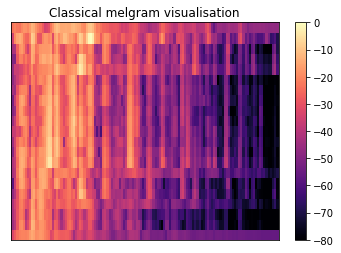

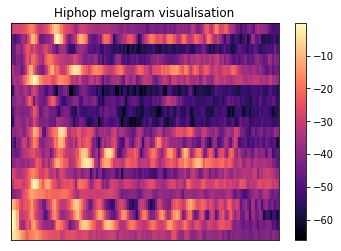

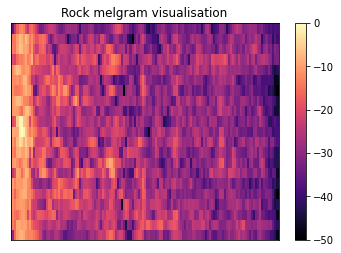

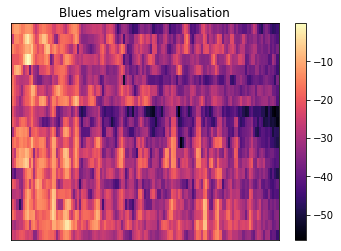

In [ ]:
import os
import glob
from google.colab import drive
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import librosa
import librosa.display
import random

#load files as arrays
train_melgrams_X = np.load("/content/drive/MyDrive/music_genre_data_di/train/melgrams/X.npy")
train_melgrams_labels = np.load("/content/drive/MyDrive/music_genre_data_di/train/melgrams/labels.npy")
test_melgrams_X = np.load("/content/drive/MyDrive/music_genre_data_di/test/melgrams/X.npy")
test_melgrams_labels = np.load("/content/drive/MyDrive/music_genre_data_di/test/melgrams/labels.npy")
val_melgrams_X = np.load("/content/drive/MyDrive/music_genre_data_di/val/melgrams/X.npy")
val_melgrams_labels = np.load("/content/drive/MyDrive/music_genre_data_di/val/melgrams/labels.npy")

#give a number to each category
categories = ["classical","hiphop","rock_metal_hardrock","blues"]
num_categories = dict(zip(categories,range(0,4)))

#for test set
test_labels = (pd.Series(test_melgrams_labels)).map(num_categories)
test_labels = list(test_labels)
testdata = list(zip(test_melgrams_X,test_labels))

#for train set
train_labels = (pd.Series(train_melgrams_labels)).map(num_categories)
train_labels = list(train_labels)
traindata = list(zip(train_melgrams_X,train_labels))

#for val set
val_labels = (pd.Series(val_melgrams_labels)).map(num_categories)
val_labels = list(val_labels)
valdata = list(zip(val_melgrams_X,val_labels))

#Dataloaders
traindataloader = DataLoader(traindata,batch_size = 16, shuffle=True)
testdataloader = DataLoader(testdata,batch_size=16,shuffle=False)
valdataloader = DataLoader(valdata,batch_size=16,shuffle=True)


#visualisation
classical = []
hiphop = []
rock = []
blues = []

for i in range(0,len(traindata)):
  if traindata[i][1] == 0:
    classical.append(train_melgrams_X[i])

for i in range(0,len(traindata)):
  if traindata[i][1] == 1:
    hiphop.append(train_melgrams_X[i])

for i in range(0,len(traindata)):
  if traindata[i][1] == 2:
    rock.append(train_melgrams_X[i])

for i in range(0,len(traindata)):
  if traindata[i][1] == 3:
    blues.append(train_melgrams_X[i])

#from train set

#classical music
number = random.randint(0,len(classical)-1)
plt.figure()
librosa.display.specshow(classical[number])
plt.colorbar()
plt.title("Classical melgram visualisation")

#hiphop
number = random.randint(0,len(hiphop)-1)
plt.figure()
librosa.display.specshow(hiphop[number])
plt.colorbar()
plt.title("Hiphop melgram visualisation")

#rock-metal
number = random.randint(0,len(rock)-1)
plt.figure()
librosa.display.specshow(rock[number])
plt.colorbar()
plt.title("Rock melgram visualisation")

#blues
number = random.randint(0,len(blues)-1)
plt.figure()
librosa.display.specshow(blues[number])
plt.colorbar()
plt.title("Blues melgram visualisation")

***Step 2: Define Neural Network***

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
      super().__init__()

      #in/out channels: 1,16,32,64,128, kernel size = 5
      self.conv1 = nn.Conv2d(1, 16, 5)
      self.conv2 = nn.Conv2d(16, 32, 5)
      self.conv3 = nn.Conv2d(32, 64, 5)
      self.conv4 = nn.Conv2d(64, 128, 5)

      self.fc1 = nn.Linear(1024, 1024)
      self.fc2 = nn.Linear(1024, 256)
      self.fc3 = nn.Linear(256, 32)
      self.fc4 = nn.Linear(32, 4)

    # x represents our data
    def forward(self, x):

      x = torch.unsqueeze(x,1)

      x = self.conv1(x)

      x = self.conv2(x)

      x = self.conv3(x)

      x = self.conv4(x)

      x= x.view(x.size(0),-1)

      x = self.fc1(x)

      x = self.fc2(x)

      x = self.fc3(x)

      x = self.fc4(x)

      return x

***Step 3: Network Training***

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

def trainCNN(num_epochs,optimizer,trainloader,validloader,lossfun,cnn):
  min_valid_loss = np.inf
  size = len(trainloader.dataset)
  for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}\n------------------")
    train_loss = 0.0
    cnn.train()
    for i, (X, labels) in enumerate(trainloader):
        X = X.type(torch.FloatTensor)
        output = cnn(X)
        loss = lossfun(output, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if i%10 == 0:
          loss,current = loss.item(), i*len(X)
          print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    print("\n")

    valid_loss = 0.0
    cnn.eval()
    for X, labels in validloader:
      X = X.type(torch.FloatTensor)
      output = cnn(X)
      loss = lossfun(output, labels)
      valid_loss += loss.item()

    if min_valid_loss > valid_loss:
        min_valid_loss = valid_loss

        # Saving State Dict
        torch.save(cnn.state_dict(), 'saved_model.pth')
  return cnn

def testCNN(dataloader,lossfun,cnn):

  cnn.eval()

  correct = 0
  total = 0
  test_loss = 0
  size = len(dataloader.dataset)
  y_true = []
  y_pred = []

  # Iterate through test dataset
  with torch.no_grad():
    for X, labels in dataloader:
      X = X.type(torch.float)
      output = cnn(X)
      test_loss += lossfun(output, labels).item()
      correct += (output.argmax(1)==labels).type(torch.float).sum().item()
      y_true.append(labels)
      y_pred.append(output.argmax(1))

  y_true = torch.cat(y_true)
  y_pred = torch.cat(y_pred)

  correct /= size
  accuracy = 100*correct
  test_loss /= size
  f1 = f1_score(y_true,y_pred,average='macro')
  cm = confusion_matrix(y_true,y_pred)
  return test_loss,f1,accuracy,cm

In [ ]:
num_epochs = 30
lossfun = nn.CrossEntropyLoss()
learning_rate = 0.002
cnn_model_cpu = CNN()
optimizer = torch.optim.SGD(cnn_model_cpu.parameters(), lr=learning_rate)

#train
cnn_model_cpu = trainCNN(num_epochs,optimizer,traindataloader,valdataloader,lossfun,cnn_model_cpu)

Epoch: 1
------------------


RuntimeError: ignored

Network cannot be trained. We need pooling and padding metrics:

***Step 4: Pooling and padding***

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNnew(nn.Module):
    def __init__(self):
      super().__init__()

      #in/out channels: 1,16,32,64,128, kernel size = 5
      self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
      self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
      self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
      self.conv4 = nn.Conv2d(64, 128, 5, padding=2)

      self.max_pool = nn.MaxPool2d(kernel_size=2)

      self.fc1 = nn.Linear(1024, 1024)
      self.fc2 = nn.Linear(1024, 256)
      self.fc3 = nn.Linear(256, 32)
      self.fc4 = nn.Linear(32, 4)

    # x represents our data
    def forward(self, x):

      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x = self.max_pool(x)

      x = self.conv2(x)
      x = self.max_pool(x)

      x = self.conv3(x)
      x = self.max_pool(x)

      x = self.conv4(x)
      x = self.max_pool(x)

      x= x.view(x.size(0),-1)

      x = self.fc1(x)

      x = self.fc2(x)

      x = self.fc3(x)

      x = self.fc4(x)

      return x

In [ ]:
num_epochs = 30
lossfun = nn.CrossEntropyLoss()
learning_rate = 0.002
cnn_model_cpu = CNNnew()
optimizer = torch.optim.SGD(cnn_model_cpu.parameters(), lr=learning_rate)

#train
cnn_model_cpu = trainCNN(num_epochs,optimizer,traindataloader,valdataloader,lossfun,cnn_model_cpu)

Epoch: 1
------------------
loss: 1.301586 [    0/ 3200]
loss: 1.379985 [  160/ 3200]
loss: 1.368546 [  320/ 3200]
loss: 1.498016 [  480/ 3200]
loss: 1.368024 [  640/ 3200]
loss: 1.344743 [  800/ 3200]
loss: 1.305199 [  960/ 3200]
loss: 1.426642 [ 1120/ 3200]
loss: 1.474251 [ 1280/ 3200]
loss: 1.326331 [ 1440/ 3200]
loss: 1.279463 [ 1600/ 3200]
loss: 1.274236 [ 1760/ 3200]
loss: 1.199026 [ 1920/ 3200]
loss: 1.288182 [ 2080/ 3200]
loss: 1.189274 [ 2240/ 3200]
loss: 1.278201 [ 2400/ 3200]
loss: 1.360150 [ 2560/ 3200]
loss: 1.308775 [ 2720/ 3200]
loss: 1.197020 [ 2880/ 3200]
loss: 1.218017 [ 3040/ 3200]


Epoch: 2
------------------
loss: 1.216144 [    0/ 3200]
loss: 1.208267 [  160/ 3200]
loss: 1.447653 [  320/ 3200]
loss: 1.461327 [  480/ 3200]
loss: 1.294999 [  640/ 3200]
loss: 1.175988 [  800/ 3200]
loss: 1.404074 [  960/ 3200]
loss: 1.123342 [ 1120/ 3200]
loss: 1.039132 [ 1280/ 3200]
loss: 1.120132 [ 1440/ 3200]
loss: 1.238570 [ 1600/ 3200]
loss: 1.521890 [ 1760/ 3200]
loss: 1.087793

In [ ]:
#test
loss,f1,accuracy,cm = testCNN(testdataloader,lossfun,cnn_model_cpu)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracy:>0.1f}%\nF1 macro averaged: {f1:>8f}\nConfusion matrix: {cm}")

Loss: 0.080100
Accuracy: 70.1%
F1 macro averaged: 0.706391
Confusion matrix: [[252   6   7  32]
 [  7 279  39  31]
 [ 15  48 242  94]
 [ 16  42  75 191]]


***Step 5: Optimization algorithms***

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

def trainCNN(num_epochs,optimizer,trainloader,validloader,lossfun,cnn):
  min_valid_loss = np.inf
  size = len(trainloader.dataset)
  for epoch in range(num_epochs):
    train_loss = 0.0
    cnn.train()
    for i, (X, labels) in enumerate(trainloader):
        X = X.type(torch.FloatTensor)
        output = cnn(X)
        loss = lossfun(output, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if i%10 == 0:
          loss,current = loss.item(), i*len(X)

    valid_loss = 0.0
    cnn.eval()
    for X, labels in validloader:
      X = X.type(torch.FloatTensor)
      output = cnn(X)
      loss = lossfun(output, labels)
      valid_loss += loss.item()

    if min_valid_loss > valid_loss:
      min_valid_loss = valid_loss

      # Saving State Dict
      torch.save(cnn.state_dict(), 'saved_model.pth')
  return cnn

def testCNN(dataloader,lossfun,cnn):

  cnn.eval()

  correct = 0
  total = 0
  test_loss = 0
  size = len(dataloader.dataset)
  y_true = []
  y_pred = []

  # Iterate through test dataset
  with torch.no_grad():
    for X, labels in dataloader:
      X = X.type(torch.float)
      output = cnn(X)
      test_loss += lossfun(output, labels).item()
      correct += (output.argmax(1)==labels).type(torch.float).sum().item()
      y_true.append(labels)
      y_pred.append(output.argmax(1))

  y_true = torch.cat(y_true)
  y_pred = torch.cat(y_pred)

  correct /= size
  accuracy = 100*correct
  test_loss /= size
  f1 = f1_score(y_true,y_pred,average='macro')
  cm = confusion_matrix(y_true,y_pred)
  return test_loss,f1,accuracy,cm

In [ ]:
num_epochs = 30
lossfun = nn.CrossEntropyLoss()
learning_rate = 0.002
cnn_model_cpu = CNNnew()

#adadelta
optimizer = torch.optim.Adadelta(cnn_model_cpu.parameters(), lr=learning_rate)
#train
cnn_model_opt_adadelta = trainCNN(num_epochs,optimizer,traindataloader,valdataloader,lossfun,cnn_model_cpu)
#test
loss,f1_adadelta,accuracy_adadelta,cm = testCNN(testdataloader,lossfun,cnn_model_opt_adadelta)

#adagrad
optimizer = torch.optim.Adagrad(cnn_model_cpu.parameters(), lr=learning_rate)
#train
cnn_model_opt_adagrad = trainCNN(num_epochs,optimizer,traindataloader,valdataloader,lossfun,cnn_model_cpu)
#test
loss,f1_adagrad,accuracy_adagrad,cm = testCNN(testdataloader,lossfun,cnn_model_opt_adagrad)

#adam
optimizer = torch.optim.Adam(cnn_model_cpu.parameters(), lr=learning_rate)
#train
cnn_model_opt_adam = trainCNN(num_epochs,optimizer,traindataloader,valdataloader,lossfun,cnn_model_cpu)
#test
loss,f1_adam,accuracy_adam,cm = testCNN(testdataloader,lossfun,cnn_model_opt_adam)

#adamw
optimizer = torch.optim.AdamW(cnn_model_cpu.parameters(), lr=learning_rate)
#train
cnn_model_opt_adamw = trainCNN(num_epochs,optimizer,traindataloader,valdataloader,lossfun,cnn_model_cpu)
#test
loss,f1_adamw,accuracy_adamw,cm = testCNN(testdataloader,lossfun,cnn_model_opt_adamw)


#adamax
optimizer = torch.optim.Adamax(cnn_model_cpu.parameters(), lr=learning_rate)
#train
cnn_model_opt_adamax = trainCNN(num_epochs,optimizer,traindataloader,valdataloader,lossfun,cnn_model_cpu)
#test
loss,f1_adamax,accuracy_adamax,cm = testCNN(testdataloader,lossfun,cnn_model_opt_adamax)

#ASGD
optimizer = torch.optim.ASGD(cnn_model_cpu.parameters(), lr=learning_rate)
#train
cnn_model_opt_ASGD = trainCNN(num_epochs,optimizer,traindataloader,valdataloader,lossfun,cnn_model_cpu)
#test
loss,f1_ASGD,accuracy_ASGD,cm = testCNN(testdataloader,lossfun,cnn_model_opt_ASGD)


#Nadam
optimizer = torch.optim.NAdam(cnn_model_cpu.parameters(), lr=learning_rate)
#train
cnn_model_opt_nadam = trainCNN(num_epochs,optimizer,traindataloader,valdataloader,lossfun,cnn_model_cpu)
#test
loss,f1_nadam,accuracy_nadam,cm = testCNN(testdataloader,lossfun,cnn_model_opt_nadam)

#radam
optimizer = torch.optim.RAdam(cnn_model_cpu.parameters(), lr=learning_rate)
#train
cnn_model_opt_radam = trainCNN(num_epochs,optimizer,traindataloader,valdataloader,lossfun,cnn_model_cpu)
#test
loss,f1_radam,accuracy_radam,cm = testCNN(testdataloader,lossfun,cnn_model_opt_radam)

#rmsprop
optimizer = torch.optim.RMSprop(cnn_model_cpu.parameters(), lr=learning_rate)
#train
cnn_model_opt_rmsprop = trainCNN(num_epochs,optimizer,traindataloader,valdataloader,lossfun,cnn_model_cpu)
#test
loss,f1_rmsprop,accuracy_rmsprop,cm = testCNN(testdataloader,lossfun,cnn_model_opt_rmsprop)

#rprop
optimizer = torch.optim.Rprop(cnn_model_cpu.parameters(), lr=learning_rate)
#train
cnn_model_opt_rprop = trainCNN(num_epochs,optimizer,traindataloader,valdataloader,lossfun,cnn_model_cpu)
#test
loss,f1_rprop,accuracy_rprop,cm = testCNN(testdataloader,lossfun,cnn_model_opt_rprop)

In [ ]:
#print table
print ("{:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20}".format('Acc-f1/opt','Adadelta','Adagrad','Adam','AdamW','Adamax','ASGD','NAdam','RAdam','RMSprop','Rprop','SGD'))
print("{:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} ".format('Accuracy',accuracy_adadelta,accuracy_adagrad,accuracy_adam,accuracy_adamw,accuracy_adamax,accuracy_ASGD,accuracy_nadam,accuracy_radam,accuracy_rmsprop,accuracy_rprop,accuracy))
print("{:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} ".format('F1',f1_adadelta,f1_adagrad,f1_adam,f1_adamw,f1_adamax,f1_ASGD,f1_nadam,f1_radam,f1_rmsprop,f1_rprop,f1))

Acc-f1/opt           Adadelta             Adagrad              Adam                 AdamW                Adamax               ASGD                 NAdam                RAdam                RMSprop              Rprop                SGD                 
Accuracy             65.26162790697676    73.69186046511628    63.372093023255815   71.51162790697676    72.31104651162791    72.38372093023256    61.19186046511628    21.584302325581394   21.584302325581394   21.584302325581394   71.43895348837209    
F1                   0.6632756534164601   0.742461357845221    0.5874540628799221   0.7162392817526956   0.7248816838309695   0.725684533389867    0.6183975304279408   0.08876270173341302  0.08876270173341302  0.08876270173341302  0.7206613355256255   


Accuracy and f1 score of adagrad optimizer are the best.

# **Q3: Improving Performance**

***Step 1: Reproducibility***

In [ ]:
import numpy as np
import random,os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, confusion_matrix

def torch_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def train(reproducibility=True, num_epochs=30, device='cuda'):
  min_valid_loss = np.inf
  for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}\n------------------")

    if reproducibility:
      torch_seed(seed=0)

    cnn = CNNnew().to(device)
    lossfun = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adagrad(cnn.parameters(),lr=0.002,weight_decay=0.0)

    loss_avg = 0.0
    cnn.train()
    for i, (X, labels) in enumerate(traindataloader):
      #gpu
      X = X.to(device)
      labels = labels.to(device)

      X = X.type(torch.FloatTensor)
      optimizer.zero_grad()
      output = cnn(X.to(device))
      loss = lossfun(output, labels.to(device))
      loss_avg = (loss_avg*i+loss)/(i+1)
      loss.backward()
      optimizer.step()

      if i%10 == 0:
        print('[%d,%4d] loss: %.4f' %(i+1,len(traindataloader),loss_avg))
    print("\n")

    valid_loss = 0.0
    cnn.eval()
    for X, labels in valdataloader:
      #gpu
      X = X.to(device)
      labels = labels.to(device)
      X = X.type(torch.FloatTensor)
      output = cnn(X.to(device))
      loss = lossfun(output, labels.to(device))
      valid_loss += loss.item()

    if min_valid_loss > valid_loss:
      min_valid_loss = valid_loss

      # Saving State Dict
      torch.save(cnn.state_dict(), 'saved_model.pth')

  return cnn

def test(cnn,device='cuda'):

  correct = 0
  total = 0
  test_loss = 0
  size = len(testdataloader.dataset)
  lossfun = nn.CrossEntropyLoss().to(device)
  y_true = []
  y_pred = []

  with torch.no_grad():
    for X, labels in testdataloader:
      #gpu
      X = X.to(device)
      labels = labels.to(device)

      X = X.type(torch.float)
      output = cnn(X)
      test_loss += lossfun(output, labels).item()
      correct += (output.argmax(1)==labels).type(torch.float).sum().item()
      y_true.append(labels)
      y_pred.append(output.argmax(1))

  y_true = torch.cat(y_true)
  y_pred = torch.cat(y_pred)

  correct /= size
  accuracy = 100*correct
  test_loss /= size

  y_true = y_true.cpu()
  y_pred = y_pred.cpu()

  f1 = f1_score(y_true,y_pred,average='macro')
  cm = confusion_matrix(y_true,y_pred)
  return test_loss,f1,accuracy,cm

In [ ]:
cnn = train(reproducibility=False)

Epoch: 1
------------------
[1, 200] loss: 1.4187
[11, 200] loss: 16.6434
[21, 200] loss: 9.5362
[31, 200] loss: 6.9246
[41, 200] loss: 5.5738
[51, 200] loss: 4.7502
[61, 200] loss: 4.1961
[71, 200] loss: 3.7984
[81, 200] loss: 3.4971
[91, 200] loss: 3.2553
[101, 200] loss: 3.0633
[111, 200] loss: 2.9022
[121, 200] loss: 2.7688
[131, 200] loss: 2.6546
[141, 200] loss: 2.5552
[151, 200] loss: 2.4712
[161, 200] loss: 2.3968
[171, 200] loss: 2.3297
[181, 200] loss: 2.2710
[191, 200] loss: 2.2153


Epoch: 2
------------------
[1, 200] loss: 1.3310
[11, 200] loss: 28.1066
[21, 200] loss: 15.4677
[31, 200] loss: 10.9218
[41, 200] loss: 8.5987
[51, 200] loss: 7.1793
[61, 200] loss: 6.2238
[71, 200] loss: 5.5410
[81, 200] loss: 5.0196
[91, 200] loss: 4.6150
[101, 200] loss: 4.2885
[111, 200] loss: 4.0191
[121, 200] loss: 3.7927
[131, 200] loss: 3.6042
[141, 200] loss: 3.4368
[151, 200] loss: 3.2920
[161, 200] loss: 3.1605
[171, 200] loss: 3.0480
[181, 200] loss: 2.9464
[191, 200] loss: 2.8555


In [ ]:
#test
loss,f1,accuracy,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracy:>0.1f}%\nF1 macro averaged: {f1:>8f}\nConfusion matrix: {cm}")

Loss: 0.066257
Accuracy: 52.0%
F1 macro averaged: 0.459466
Confusion matrix: [[281  10   0   6]
 [  8 305   1  42]
 [ 42 194   7 156]
 [ 51 151   0 122]]


With reproducibility=False we receive a different loss in each epoch. On the contrary:

In [ ]:
cnn = train(reproducibility=True)

Epoch: 1
------------------
[1, 200] loss: 1.3874
[11, 200] loss: 21.5548
[21, 200] loss: 12.0052
[31, 200] loss: 8.5890
[41, 200] loss: 6.8233
[51, 200] loss: 5.7557
[61, 200] loss: 5.0319
[71, 200] loss: 4.5135
[81, 200] loss: 4.1183
[91, 200] loss: 3.8103
[101, 200] loss: 3.5636
[111, 200] loss: 3.3610
[121, 200] loss: 3.1906
[131, 200] loss: 3.0440
[141, 200] loss: 2.9188
[151, 200] loss: 2.8095
[161, 200] loss: 2.7118
[171, 200] loss: 2.6274
[181, 200] loss: 2.5524
[191, 200] loss: 2.4831


Epoch: 2
------------------
[1, 200] loss: 1.3874
[11, 200] loss: 21.5548
[21, 200] loss: 12.0052
[31, 200] loss: 8.5890
[41, 200] loss: 6.8233
[51, 200] loss: 5.7557
[61, 200] loss: 5.0319
[71, 200] loss: 4.5135
[81, 200] loss: 4.1183
[91, 200] loss: 3.8103
[101, 200] loss: 3.5636
[111, 200] loss: 3.3610
[121, 200] loss: 3.1906
[131, 200] loss: 3.0440
[141, 200] loss: 2.9188
[151, 200] loss: 2.8095
[161, 200] loss: 2.7118
[171, 200] loss: 2.6274
[181, 200] loss: 2.5524
[191, 200] loss: 2.4831


In [ ]:
#test
loss,f1,accuracy,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracy:>0.1f}%\nF1 macro averaged: {f1:>8f}\nConfusion matrix: {cm}")

Loss: 0.085846
Accuracy: 42.2%
F1 macro averaged: 0.328881
Confusion matrix: [[225  72   0   0]
 [  7 348   0   1]
 [ 18 376   0   5]
 [ 20 297   0   7]]


With reproducibility=True we receive the same loss in each epoch.

***Step 2: Activation functions***

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#relu activation
class CNNrelu(nn.Module):
    def __init__(self):
      super().__init__()

      #in/out channels: 1,16,32,64,128, kernel size = 5
      self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
      self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
      self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
      self.conv4 = nn.Conv2d(64, 128, 5, padding=2)

      self.max_pool = nn.MaxPool2d(kernel_size=2)

      self.fc1 = nn.Linear(1024, 1024)
      self.fc2 = nn.Linear(1024, 256)
      self.fc3 = nn.Linear(256, 32)
      self.fc4 = nn.Linear(32, 4)

    # x represents our data
    def forward(self, x):

      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x = F.relu(x)
      x = self.max_pool(x)

      x = self.conv2(x)
      x = F.relu(x)
      x = self.max_pool(x)

      x = self.conv3(x)
      x = F.relu(x)
      x = self.max_pool(x)

      x = self.conv4(x)
      x = F.relu(x)
      x = self.max_pool(x)

      x= x.view(x.size(0),-1)

      x = self.fc1(x)
      x = F.relu(x)

      x = self.fc2(x)
      x = F.relu(x)

      x = self.fc3(x)
      x = F.relu(x)

      x = self.fc4(x)

      return x

def trainrelu(reproducibility=True, num_epochs=30, device='cuda'):
  min_valid_loss = np.inf
  for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}\n------------------")

    if reproducibility:
      torch_seed(seed=0)

    cnn = CNNrelu().to(device)
    lossfun = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adagrad(cnn.parameters(),lr=0.002,weight_decay=0.0)

    loss_avg = 0.0
    cnn.train()
    for i, (X, labels) in enumerate(traindataloader):
      #gpu
      X = X.to(device)
      labels = labels.to(device)

      X = X.type(torch.FloatTensor)
      optimizer.zero_grad()
      output = cnn(X.to(device))
      loss = lossfun(output, labels.to(device))
      loss_avg = (loss_avg*i+loss)/(i+1)
      loss.backward()
      optimizer.step()

      if i%10 == 0:
        print('[%d,%4d] loss: %.4f' %(i+1,len(traindataloader),loss_avg))
    print("\n")

    valid_loss = 0.0
    cnn.eval()
    for X, labels in valdataloader:
      #gpu
      X = X.to(device)
      labels = labels.to(device)
      X = X.type(torch.FloatTensor)
      output = cnn(X.to(device))
      loss = lossfun(output, labels.to(device))
      valid_loss += loss.item()

    if min_valid_loss > valid_loss:
      min_valid_loss = valid_loss

      # Saving State Dict
      torch.save(cnn.state_dict(), 'saved_model.pth')

  return cnn

#softsign activation
class CNNsoftsign(nn.Module):
    def __init__(self):
      super().__init__()

      #in/out channels: 1,16,32,64,128, kernel size = 5
      self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
      self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
      self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
      self.conv4 = nn.Conv2d(64, 128, 5, padding=2)

      self.max_pool = nn.MaxPool2d(kernel_size=2)

      self.fc1 = nn.Linear(1024, 1024)
      self.fc2 = nn.Linear(1024, 256)
      self.fc3 = nn.Linear(256, 32)
      self.fc4 = nn.Linear(32, 4)

    # x represents our data
    def forward(self, x):

      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x = F.softsign(x)
      x = self.max_pool(x)

      x = self.conv2(x)
      x = F.softsign(x)
      x = self.max_pool(x)

      x = self.conv3(x)
      x = F.softsign(x)
      x = self.max_pool(x)

      x = self.conv4(x)
      x = F.softsign(x)
      x = self.max_pool(x)

      x= x.view(x.size(0),-1)

      x = self.fc1(x)
      x = F.softsign(x)

      x = self.fc2(x)
      x = F.softsign(x)

      x = self.fc3(x)
      x = F.softsign(x)

      x = self.fc4(x)

      return x

def trainsoftsign(reproducibility=True, num_epochs=30, device='cuda'):
  min_valid_loss = np.inf
  for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}\n------------------")

    if reproducibility:
      torch_seed(seed=0)

    cnn = CNNsoftsign().to(device)
    lossfun = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adagrad(cnn.parameters(),lr=0.002,weight_decay=0.0)

    loss_avg = 0.0
    cnn.train()
    for i, (X, labels) in enumerate(traindataloader):
      #gpu
      X = X.to(device)
      labels = labels.to(device)

      X = X.type(torch.FloatTensor)
      optimizer.zero_grad()
      output = cnn(X.to(device))
      loss = lossfun(output, labels.to(device))
      loss_avg = (loss_avg*i+loss)/(i+1)
      loss.backward()
      optimizer.step()

      if i%10 == 0:
        print('[%d,%4d] loss: %.4f' %(i+1,len(traindataloader),loss_avg))
    print("\n")

    valid_loss = 0.0
    cnn.eval()
    for X, labels in valdataloader:
      #gpu
      X = X.to(device)
      labels = labels.to(device)
      X = X.type(torch.FloatTensor)
      output = cnn(X.to(device))
      loss = lossfun(output, labels.to(device))
      valid_loss += loss.item()

    if min_valid_loss > valid_loss:
      min_valid_loss = valid_loss

      # Saving State Dict
      torch.save(cnn.state_dict(), 'saved_model.pth')

  return cnn

#elu activation
class CNNelu(nn.Module):
    def __init__(self):
      super().__init__()

      #in/out channels: 1,16,32,64,128, kernel size = 5
      self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
      self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
      self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
      self.conv4 = nn.Conv2d(64, 128, 5, padding=2)

      self.max_pool = nn.MaxPool2d(kernel_size=2)

      self.fc1 = nn.Linear(1024, 1024)
      self.fc2 = nn.Linear(1024, 256)
      self.fc3 = nn.Linear(256, 32)
      self.fc4 = nn.Linear(32, 4)

    # x represents our data
    def forward(self, x):

      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x = F.elu(x)
      x = self.max_pool(x)

      x = self.conv2(x)
      x = F.elu(x)
      x = self.max_pool(x)

      x = self.conv3(x)
      x = F.elu(x)
      x = self.max_pool(x)

      x = self.conv4(x)
      x = F.elu(x)
      x = self.max_pool(x)

      x= x.view(x.size(0),-1)

      x = self.fc1(x)
      x = F.elu(x)

      x = self.fc2(x)
      x = F.elu(x)

      x = self.fc3(x)
      x = F.elu(x)

      x = self.fc4(x)

      return x

def trainelu(reproducibility=True, num_epochs=30, device='cuda'):
  min_valid_loss = np.inf
  for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}\n------------------")

    if reproducibility:
      torch_seed(seed=0)

    cnn = CNNelu().to(device)
    lossfun = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adagrad(cnn.parameters(),lr=0.002,weight_decay=0.0)

    loss_avg = 0.0
    cnn.train()
    for i, (X, labels) in enumerate(traindataloader):
      #gpu
      X = X.to(device)
      labels = labels.to(device)

      X = X.type(torch.FloatTensor)
      optimizer.zero_grad()
      output = cnn(X.to(device))
      loss = lossfun(output, labels.to(device))
      loss_avg = (loss_avg*i+loss)/(i+1)
      loss.backward()
      optimizer.step()

      if i%10 == 0:
        print('[%d,%4d] loss: %.4f' %(i+1,len(traindataloader),loss_avg))
    print("\n")

    valid_loss = 0.0
    cnn.eval()
    for X, labels in valdataloader:
      #gpu
      X = X.to(device)
      labels = labels.to(device)
      X = X.type(torch.FloatTensor)
      output = cnn(X.to(device))
      loss = lossfun(output, labels.to(device))
      valid_loss += loss.item()

    if min_valid_loss > valid_loss:
      min_valid_loss = valid_loss

      # Saving State Dict
      torch.save(cnn.state_dict(), 'saved_model.pth')

  return cnn

#rrelu activation
class CNNrrelu(nn.Module):
    def __init__(self):
      super().__init__()

      #in/out channels: 1,16,32,64,128, kernel size = 5
      self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
      self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
      self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
      self.conv4 = nn.Conv2d(64, 128, 5, padding=2)

      self.max_pool = nn.MaxPool2d(kernel_size=2)

      self.fc1 = nn.Linear(1024, 1024)
      self.fc2 = nn.Linear(1024, 256)
      self.fc3 = nn.Linear(256, 32)
      self.fc4 = nn.Linear(32, 4)

    # x represents our data
    def forward(self, x):

      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x = F.rrelu(x)
      x = self.max_pool(x)

      x = self.conv2(x)
      x = F.rrelu(x)
      x = self.max_pool(x)

      x = self.conv3(x)
      x = F.rrelu(x)
      x = self.max_pool(x)

      x = self.conv4(x)
      x = F.rrelu(x)
      x = self.max_pool(x)

      x= x.view(x.size(0),-1)

      x = self.fc1(x)
      x = F.rrelu(x)

      x = self.fc2(x)
      x = F.rrelu(x)

      x = self.fc3(x)
      x = F.rrelu(x)

      x = self.fc4(x)

      return x

def trainrrelu(reproducibility=True, num_epochs=30, device='cuda'):
  min_valid_loss = np.inf
  for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}\n------------------")

    if reproducibility:
      torch_seed(seed=0)

    cnn = CNNrrelu().to(device)
    lossfun = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adagrad(cnn.parameters(),lr=0.002,weight_decay=0.0)

    loss_avg = 0.0
    cnn.train()
    for i, (X, labels) in enumerate(traindataloader):
      #gpu
      X = X.to(device)
      labels = labels.to(device)

      X = X.type(torch.FloatTensor)
      optimizer.zero_grad()
      output = cnn(X.to(device))
      loss = lossfun(output, labels.to(device))
      loss_avg = (loss_avg*i+loss)/(i+1)
      loss.backward()
      optimizer.step()

      if i%10 == 0:
        print('[%d,%4d] loss: %.4f' %(i+1,len(traindataloader),loss_avg))
    print("\n")

    valid_loss = 0.0
    cnn.eval()
    for X, labels in valdataloader:
      #gpu
      X = X.to(device)
      labels = labels.to(device)
      X = X.type(torch.FloatTensor)
      output = cnn(X.to(device))
      loss = lossfun(output, labels.to(device))
      valid_loss += loss.item()

    if min_valid_loss > valid_loss:
      min_valid_loss = valid_loss

      # Saving State Dict
      torch.save(cnn.state_dict(), 'saved_model.pth')

  return cnn

#gelu activation
class CNNgelu(nn.Module):
    def __init__(self):
      super().__init__()

      #in/out channels: 1,16,32,64,128, kernel size = 5
      self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
      self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
      self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
      self.conv4 = nn.Conv2d(64, 128, 5, padding=2)

      self.max_pool = nn.MaxPool2d(kernel_size=2)

      self.fc1 = nn.Linear(1024, 1024)
      self.fc2 = nn.Linear(1024, 256)
      self.fc3 = nn.Linear(256, 32)
      self.fc4 = nn.Linear(32, 4)

    # x represents our data
    def forward(self, x):

      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x = F.gelu(x)
      x = self.max_pool(x)

      x = self.conv2(x)
      x = F.gelu(x)
      x = self.max_pool(x)

      x = self.conv3(x)
      x = F.gelu(x)
      x = self.max_pool(x)

      x = self.conv4(x)
      x = F.gelu(x)
      x = self.max_pool(x)

      x= x.view(x.size(0),-1)

      x = self.fc1(x)
      x = F.gelu(x)

      x = self.fc2(x)
      x = F.gelu(x)

      x = self.fc3(x)
      x = F.gelu(x)

      x = self.fc4(x)

      return x

def traingelu(reproducibility=True, num_epochs=30, device='cuda'):
  min_valid_loss = np.inf
  for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}\n------------------")

    if reproducibility:
      torch_seed(seed=0)

    cnn = CNNgelu().to(device)
    lossfun = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adagrad(cnn.parameters(),lr=0.002,weight_decay=0.0)

    loss_avg = 0.0
    cnn.train()
    for i, (X, labels) in enumerate(traindataloader):
      #gpu
      X = X.to(device)
      labels = labels.to(device)

      X = X.type(torch.FloatTensor)
      optimizer.zero_grad()
      output = cnn(X.to(device))
      loss = lossfun(output, labels.to(device))
      loss_avg = (loss_avg*i+loss)/(i+1)
      loss.backward()
      optimizer.step()

      if i%10 == 0:
        print('[%d,%4d] loss: %.4f' %(i+1,len(traindataloader),loss_avg))
    print("\n")

    valid_loss = 0.0
    cnn.eval()
    for X, labels in valdataloader:
      #gpu
      X = X.to(device)
      labels = labels.to(device)
      X = X.type(torch.FloatTensor)
      output = cnn(X.to(device))
      loss = lossfun(output, labels.to(device))
      valid_loss += loss.item()

    if min_valid_loss > valid_loss:
      min_valid_loss = valid_loss

      # Saving State Dict
      torch.save(cnn.state_dict(), 'saved_model.pth')

  return cnn

#hardshrink activation
class CNNhardshrink(nn.Module):
    def __init__(self):
      super().__init__()

      #in/out channels: 1,16,32,64,128, kernel size = 5
      self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
      self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
      self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
      self.conv4 = nn.Conv2d(64, 128, 5, padding=2)

      self.max_pool = nn.MaxPool2d(kernel_size=2)

      self.fc1 = nn.Linear(1024, 1024)
      self.fc2 = nn.Linear(1024, 256)
      self.fc3 = nn.Linear(256, 32)
      self.fc4 = nn.Linear(32, 4)

    # x represents our data
    def forward(self, x):

      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x = F.hardshrink(x)
      x = self.max_pool(x)

      x = self.conv2(x)
      x = F.hardshrink(x)
      x = self.max_pool(x)

      x = self.conv3(x)
      x = F.hardshrink(x)
      x = self.max_pool(x)

      x = self.conv4(x)
      x = F.hardshrink(x)
      x = self.max_pool(x)

      x= x.view(x.size(0),-1)

      x = self.fc1(x)
      x = F.hardshrink(x)

      x = self.fc2(x)
      x = F.hardshrink(x)

      x = self.fc3(x)
      x = F.hardshrink(x)

      x = self.fc4(x)

      return x

def trainhardshrink(reproducibility=True, num_epochs=30, device='cuda'):
  min_valid_loss = np.inf
  for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}\n------------------")

    if reproducibility:
      torch_seed(seed=0)

    cnn = CNNhardshrink().to(device)
    lossfun = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adagrad(cnn.parameters(),lr=0.002,weight_decay=0.0)

    loss_avg = 0.0
    cnn.train()
    for i, (X, labels) in enumerate(traindataloader):
      #gpu
      X = X.to(device)
      labels = labels.to(device)

      X = X.type(torch.FloatTensor)
      optimizer.zero_grad()
      output = cnn(X.to(device))
      loss = lossfun(output, labels.to(device))
      loss_avg = (loss_avg*i+loss)/(i+1)
      loss.backward()
      optimizer.step()

      if i%10 == 0:
        print('[%d,%4d] loss: %.4f' %(i+1,len(traindataloader),loss_avg))
    print("\n")

    valid_loss = 0.0
    cnn.eval()
    for X, labels in valdataloader:
      #gpu
      X = X.to(device)
      labels = labels.to(device)
      X = X.type(torch.FloatTensor)
      output = cnn(X.to(device))
      loss = lossfun(output, labels.to(device))
      valid_loss += loss.item()

    if min_valid_loss > valid_loss:
      min_valid_loss = valid_loss

      # Saving State Dict
      torch.save(cnn.state_dict(), 'saved_model.pth')

  return cnn

In [ ]:
cnn = trainrelu(reproducibility=True)

Epoch: 1
------------------
[1, 200] loss: 1.3981
[11, 200] loss: 1.4684
[21, 200] loss: 1.4315
[31, 200] loss: 1.4192
[41, 200] loss: 1.4117
[51, 200] loss: 1.4077
[61, 200] loss: 1.4034
[71, 200] loss: 1.4000
[81, 200] loss: 1.3980
[91, 200] loss: 1.3992
[101, 200] loss: 1.3971
[111, 200] loss: 1.3928
[121, 200] loss: 1.3931
[131, 200] loss: 1.3859
[141, 200] loss: 1.3746
[151, 200] loss: 1.3661
[161, 200] loss: 1.3511
[171, 200] loss: 1.3433
[181, 200] loss: 1.3352
[191, 200] loss: 1.3216


Epoch: 2
------------------
[1, 200] loss: 1.3981
[11, 200] loss: 1.4684
[21, 200] loss: 1.4315
[31, 200] loss: 1.4192
[41, 200] loss: 1.4117
[51, 200] loss: 1.4077
[61, 200] loss: 1.4034
[71, 200] loss: 1.4000
[81, 200] loss: 1.3980
[91, 200] loss: 1.3992
[101, 200] loss: 1.3971
[111, 200] loss: 1.3928
[121, 200] loss: 1.3931
[131, 200] loss: 1.3859
[141, 200] loss: 1.3746
[151, 200] loss: 1.3661
[161, 200] loss: 1.3511
[171, 200] loss: 1.3433
[181, 200] loss: 1.3352
[191, 200] loss: 1.3216


Ep

In [ ]:
loss,f1relu,accuracyrelu,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracyrelu:>0.1f}%\nF1 macro averaged: {f1relu:>8f}\nConfusion matrix: {cm}")

Loss: 0.073233
Accuracy: 42.8%
F1 macro averaged: 0.363622
Confusion matrix: [[202  34   0  61]
 [ 11 332   0  13]
 [ 21 339   0  39]
 [ 30 239   0  55]]


In [ ]:
cnn = trainrrelu(reproducibility=True)

Epoch: 1
------------------
[1, 200] loss: 1.3973
[11, 200] loss: 1.6998
[21, 200] loss: 1.5547
[31, 200] loss: 1.5021
[41, 200] loss: 1.4747
[51, 200] loss: 1.4591
[61, 200] loss: 1.4465
[71, 200] loss: 1.4374
[81, 200] loss: 1.4307
[91, 200] loss: 1.4248
[101, 200] loss: 1.4210
[111, 200] loss: 1.4147
[121, 200] loss: 1.4062
[131, 200] loss: 1.3917
[141, 200] loss: 1.3844
[151, 200] loss: 1.3728
[161, 200] loss: 1.3557
[171, 200] loss: 1.3536
[181, 200] loss: 1.3454
[191, 200] loss: 1.3316


Epoch: 2
------------------
[1, 200] loss: 1.3973
[11, 200] loss: 1.6998
[21, 200] loss: 1.5547
[31, 200] loss: 1.5021
[41, 200] loss: 1.4747
[51, 200] loss: 1.4591
[61, 200] loss: 1.4465
[71, 200] loss: 1.4374
[81, 200] loss: 1.4307
[91, 200] loss: 1.4248
[101, 200] loss: 1.4210
[111, 200] loss: 1.4147
[121, 200] loss: 1.4062
[131, 200] loss: 1.3917
[141, 200] loss: 1.3844
[151, 200] loss: 1.3728
[161, 200] loss: 1.3557
[171, 200] loss: 1.3536
[181, 200] loss: 1.3454
[191, 200] loss: 1.3316


Ep

In [ ]:
loss,f1rrelu,accuracyrrelu,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracyrrelu:>0.1f}%\nF1 macro averaged: {f1rrelu:>8f}\nConfusion matrix: {cm}")

Loss: 0.074091
Accuracy: 40.5%
F1 macro averaged: 0.326928
Confusion matrix: [[197  52   0  48]
 [ 20 334   0   2]
 [ 22 357   0  20]
 [ 31 267   0  26]]


In [ ]:
cnn = traingelu(reproducibility=True)

Epoch: 1
------------------
[1, 200] loss: 1.3975
[11, 200] loss: 1.4755
[21, 200] loss: 1.4334
[31, 200] loss: 1.4174
[41, 200] loss: 1.4150
[51, 200] loss: 1.4062
[61, 200] loss: 1.3962
[71, 200] loss: 1.3912
[81, 200] loss: 1.3800
[91, 200] loss: 1.3672
[101, 200] loss: 1.3649
[111, 200] loss: 1.3665
[121, 200] loss: 1.3660
[131, 200] loss: 1.3599
[141, 200] loss: 1.3525
[151, 200] loss: 1.3415
[161, 200] loss: 1.3230
[171, 200] loss: 1.3140
[181, 200] loss: 1.3045
[191, 200] loss: 1.2870


Epoch: 2
------------------
[1, 200] loss: 1.3975
[11, 200] loss: 1.4755
[21, 200] loss: 1.4334
[31, 200] loss: 1.4174
[41, 200] loss: 1.4150
[51, 200] loss: 1.4062
[61, 200] loss: 1.3962
[71, 200] loss: 1.3912
[81, 200] loss: 1.3800
[91, 200] loss: 1.3672
[101, 200] loss: 1.3649
[111, 200] loss: 1.3665
[121, 200] loss: 1.3660
[131, 200] loss: 1.3599
[141, 200] loss: 1.3525
[151, 200] loss: 1.3415
[161, 200] loss: 1.3230
[171, 200] loss: 1.3140
[181, 200] loss: 1.3045
[191, 200] loss: 1.2870


Ep

In [ ]:
loss,f1gelu,accuracygelu,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracygelu:>0.1f}%\nF1 macro averaged: {f1gelu:>8f}\nConfusion matrix: {cm}")

Loss: 0.078034
Accuracy: 42.3%
F1 macro averaged: 0.355436
Confusion matrix: [[197  64   0  36]
 [  7 346   0   3]
 [ 11 350   5  33]
 [ 21 269   0  34]]


In [ ]:
cnn = trainelu(reproducibility=True)

Epoch: 1
------------------
[1, 200] loss: 1.3950
[11, 200] loss: 1.7439
[21, 200] loss: 1.5815
[31, 200] loss: 1.5189
[41, 200] loss: 1.4853
[51, 200] loss: 1.4635
[61, 200] loss: 1.4401
[71, 200] loss: 1.4444
[81, 200] loss: 1.4279
[91, 200] loss: 1.4145
[101, 200] loss: 1.4036
[111, 200] loss: 1.3875
[121, 200] loss: 1.3651
[131, 200] loss: 1.3490
[141, 200] loss: 1.3297
[151, 200] loss: 1.3101
[161, 200] loss: 1.2864
[171, 200] loss: 1.2751
[181, 200] loss: 1.2612
[191, 200] loss: 1.2425


Epoch: 2
------------------
[1, 200] loss: 1.3950
[11, 200] loss: 1.7439
[21, 200] loss: 1.5815
[31, 200] loss: 1.5189
[41, 200] loss: 1.4853
[51, 200] loss: 1.4635
[61, 200] loss: 1.4401
[71, 200] loss: 1.4444
[81, 200] loss: 1.4279
[91, 200] loss: 1.4145
[101, 200] loss: 1.4036
[111, 200] loss: 1.3875
[121, 200] loss: 1.3651
[131, 200] loss: 1.3490
[141, 200] loss: 1.3297
[151, 200] loss: 1.3101
[161, 200] loss: 1.2864
[171, 200] loss: 1.2751
[181, 200] loss: 1.2612
[191, 200] loss: 1.2425


Ep

In [ ]:
loss,f1elu,accuracyelu,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracyelu:>0.1f}%\nF1 macro averaged: {f1elu:>8f}\nConfusion matrix: {cm}")

Loss: 0.076074
Accuracy: 45.3%
F1 macro averaged: 0.415252
Confusion matrix: [[154 130   0  13]
 [  8 347   0   1]
 [  9 258  94  38]
 [ 12 270  14  28]]


In [ ]:
cnn = trainhardshrink(reproducibility=True)

Epoch: 1
------------------
[1, 200] loss: 1.3881
[11, 200] loss: 13.5994
[21, 200] loss: 7.7624
[31, 200] loss: 5.6963
[41, 200] loss: 4.6390
[51, 200] loss: 3.9873
[61, 200] loss: 3.5405
[71, 200] loss: 3.2148
[81, 200] loss: 2.9776
[91, 200] loss: 2.7903
[101, 200] loss: 2.6450
[111, 200] loss: 2.5253
[121, 200] loss: 2.4275
[131, 200] loss: 2.3399
[141, 200] loss: 2.2631
[151, 200] loss: 2.1972
[161, 200] loss: 2.1385
[171, 200] loss: 2.0900
[181, 200] loss: 2.0473
[191, 200] loss: 2.0048


Epoch: 2
------------------
[1, 200] loss: 1.3881
[11, 200] loss: 13.5994
[21, 200] loss: 7.7624
[31, 200] loss: 5.6963
[41, 200] loss: 4.6390
[51, 200] loss: 3.9873
[61, 200] loss: 3.5405
[71, 200] loss: 3.2148
[81, 200] loss: 2.9776
[91, 200] loss: 2.7903
[101, 200] loss: 2.6450
[111, 200] loss: 2.5253
[121, 200] loss: 2.4275
[131, 200] loss: 2.3399
[141, 200] loss: 2.2631
[151, 200] loss: 2.1972
[161, 200] loss: 2.1385
[171, 200] loss: 2.0900
[181, 200] loss: 2.0473
[191, 200] loss: 2.0048




In [ ]:
loss,f1hardshrink,accuracyhardshrink,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracyhardshrink:>0.1f}%\nF1 macro averaged: {f1hardshrink:>8f}\nConfusion matrix: {cm}")

Loss: 0.083922
Accuracy: 35.9%
F1 macro averaged: 0.266586
Confusion matrix: [[139 158   0   0]
 [  1 355   0   0]
 [  3 396   0   0]
 [ 11 313   0   0]]


In [ ]:
cnn = trainsoftsign(reproducibility=True)

Epoch: 1
------------------
[1, 200] loss: 1.4004
[11, 200] loss: 1.4418
[21, 200] loss: 1.4310
[31, 200] loss: 1.4177
[41, 200] loss: 1.4112
[51, 200] loss: 1.4072
[61, 200] loss: 1.4012
[71, 200] loss: 1.4015
[81, 200] loss: 1.3986
[91, 200] loss: 1.3965
[101, 200] loss: 1.3950
[111, 200] loss: 1.3916
[121, 200] loss: 1.3837
[131, 200] loss: 1.3733
[141, 200] loss: 1.3642
[151, 200] loss: 1.3544
[161, 200] loss: 1.3414
[171, 200] loss: 1.3320
[181, 200] loss: 1.3256
[191, 200] loss: 1.3151


Epoch: 2
------------------
[1, 200] loss: 1.4004
[11, 200] loss: 1.4418
[21, 200] loss: 1.4310
[31, 200] loss: 1.4177
[41, 200] loss: 1.4112
[51, 200] loss: 1.4072
[61, 200] loss: 1.4012
[71, 200] loss: 1.4015
[81, 200] loss: 1.3986
[91, 200] loss: 1.3965
[101, 200] loss: 1.3950
[111, 200] loss: 1.3916
[121, 200] loss: 1.3837
[131, 200] loss: 1.3733
[141, 200] loss: 1.3642
[151, 200] loss: 1.3544
[161, 200] loss: 1.3414
[171, 200] loss: 1.3320
[181, 200] loss: 1.3256
[191, 200] loss: 1.3151


Ep

In [ ]:
loss,f1softsign,accuracysoftsign,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracysoftsign:>0.1f}%\nF1 macro averaged: {f1softsign:>8f}\nConfusion matrix: {cm}")

Loss: 0.068166
Accuracy: 47.0%
F1 macro averaged: 0.376512
Confusion matrix: [[274  16   0   7]
 [ 11 331   0  14]
 [ 76 277   0  46]
 [ 64 217   1  42]]


In [ ]:
#print table
print ("{:<20} {:<20} {:<20}".format('activation/acc-f1','Accuracy','F1'))
print("{:<20} {:<20} {:<20}".format('ReLU',accuracyrelu,f1relu))
print("{:<20} {:<20} {:<20}".format('ELU',accuracyelu,f1elu))
print("{:<20} {:<20} {:<20}".format('Hardshrink',accuracyhardshrink,f1hardshrink))
print("{:<20} {:<20} {:<20}".format('RReLU',accuracyrrelu,f1rrelu))
print("{:<20} {:<20} {:<20}".format('GELU',accuracygelu,f1gelu))
print("{:<20} {:<20} {:<20}".format('Softsign',accuracysoftsign,f1softsign))

activation/acc-f1    Accuracy             F1                  
ReLU                 42.80523255813954    0.36362226725928304 
ELU                  45.276162790697676   0.4152520959073677  
Hardshrink           35.901162790697676   0.2665861527263734  
RReLU                40.479651162790695   0.32692847975912886 
GELU                 42.29651162790697    0.3554357517014028  
Softsign             47.020348837209305   0.37651186025921335 


***Step 3: Learning rate scheduler***

In [ ]:
import torch.optim.lr_scheduler as lrscheduler

def train(reproducibility=True, num_epochs=30, device='cuda'):
  min_valid_loss = np.inf

  for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}\n------------------")

    if reproducibility:
      torch_seed(seed=0)

    cnn = CNNrelu().to(device)
    lossfun = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adagrad(cnn.parameters(),0.002)
    scheduler1 = lrscheduler.ExponentialLR(optimizer,gamma=0.9,verbose=True)
    scheduler2 = lrscheduler.MultiStepLR(optimizer,milestones=[30,80],gamma=0.1,verbose=True)
    scheduler3 = lrscheduler.LinearLR(optimizer,verbose=True)
    scheduler4 = lrscheduler.ConstantLR(optimizer,verbose=True)

    loss_avg = 0.0
    cnn.train()
    for i, (X, labels) in enumerate(traindataloader):
        #gpu
        X = X.to(device)
        labels = labels.to(device)

        X = X.type(torch.FloatTensor)
        optimizer.zero_grad()
        output = cnn(X.to(device))
        loss = lossfun(output, labels.to(device))
        loss_avg = (loss_avg*i+loss)/(i+1)
        loss.backward()
        optimizer.step()

        if i%10 == 0:
          print('[%d,%4d] loss: %.4f' %(i+1,len(traindataloader),loss_avg))
    print("\n")

    scheduler1.step()
    scheduler2.step()
    scheduler3.step()
    scheduler4.step()

    valid_loss = 0.0
    cnn.eval()
    for X, labels in valdataloader:
      #gpu
      X = X.to(device)
      labels = labels.to(device)
      X = X.type(torch.FloatTensor)
      output = cnn(X.to(device))
      loss = lossfun(output, labels.to(device))
      valid_loss += loss.item()

    if min_valid_loss > valid_loss:
      min_valid_loss = valid_loss

      # Saving State Dict
      torch.save(cnn.state_dict(), 'saved_model.pth')

  return cnn

In [ ]:
#training with relu
cnn = train(reproducibility=True)

Epoch: 1
------------------
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
[1, 200] loss: 1.3981
[11, 200] loss: 1.4024
[21, 200] loss: 1.3969
[31, 200] loss: 1.3950
[41, 200] loss: 1.3929
[51, 200] loss: 1.3915
[61, 200] loss: 1.3862
[71, 200] loss: 1.3824
[81, 200] loss: 1.3800
[91, 200] loss: 1.3773
[101, 200] loss: 1.3756
[111, 200] loss: 1.3714
[121, 200] loss: 1.3661
[131, 200] loss: 1.3605
[141, 200] loss: 1.3546
[151, 200] loss: 1.3502
[161, 200] loss: 1.3431
[171, 200] loss: 1.3398
[181, 200] loss: 1.3376
[191, 200] loss: 1.3320


Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch: 2
------------------
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate

In [ ]:
loss,f1,accuracy,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracy:>0.1f}%\nF1 macro averaged: {f1:>8f}\nConfusion matrix: {cm}")

Loss: 0.078577
Accuracy: 36.8%
F1 macro averaged: 0.275876
Confusion matrix: [[155 142   0   0]
 [  4 352   0   0]
 [  7 392   0   0]
 [ 14 310   0   0]]


***Step 4: Batch Normalization***

In [ ]:
#relu activation
class CNNrelubatchnorm(nn.Module):
    def __init__(self):
      super().__init__()

      #in/out channels: 1,16,32,64,128, kernel size = 5
      self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
      self.conv1_bn = nn.BatchNorm2d(16)
      self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
      self.conv2_bn = nn.BatchNorm2d(32)
      self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
      self.conv3_bn = nn.BatchNorm2d(64)
      self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
      self.conv4_bn = nn.BatchNorm2d(128)

      self.max_pool = nn.MaxPool2d(kernel_size=2)

      self.fc1 = nn.Linear(1024, 1024)
      self.fc2 = nn.Linear(1024, 256)
      self.fc3 = nn.Linear(256, 32)
      self.fc4 = nn.Linear(32, 4)

    # x represents our data
    def forward(self, x):

      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x = self.conv1_bn(x)
      x = F.relu(x)
      x = self.max_pool(x)

      x = self.conv2(x)
      x = self.conv2_bn(x)
      x = F.relu(x)
      x = self.max_pool(x)

      x = self.conv3(x)
      x = self.conv3_bn(x)
      x = F.relu(x)
      x = self.max_pool(x)

      x = self.conv4(x)
      x = self.conv4_bn(x)
      x = F.relu(x)
      x = self.max_pool(x)

      x= x.view(x.size(0),-1)

      x = self.fc1(x)
      x = F.relu(x)

      x = self.fc2(x)
      x = F.relu(x)

      x = self.fc3(x)
      x = F.relu(x)

      x = self.fc4(x)

      return x

def train(reproducibility=True, num_epochs=30, device='cuda'):
  min_valid_loss = np.inf

  for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}\n------------------")

    if reproducibility:
      torch_seed(seed=0)

    cnn = CNNrelubatchnorm().to(device)
    lossfun = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adagrad(cnn.parameters(),0.002)
    scheduler1 = lrscheduler.ExponentialLR(optimizer,gamma=0.9,verbose=True)
    scheduler2 = lrscheduler.MultiStepLR(optimizer,milestones=[30,80],gamma=0.1,verbose=True)
    scheduler3 = lrscheduler.LinearLR(optimizer,verbose=True)
    scheduler4 = lrscheduler.ConstantLR(optimizer,verbose=True)

    loss_avg = 0.0
    cnn.train()
    for i, (X, labels) in enumerate(traindataloader):
        #gpu
        X = X.to(device)
        labels = labels.to(device)

        X = X.type(torch.FloatTensor)
        optimizer.zero_grad()
        output = cnn(X.to(device))
        loss = lossfun(output, labels.to(device))
        loss_avg = (loss_avg*i+loss)/(i+1)
        loss.backward()
        optimizer.step()

        if i%10 == 0:
          print('[%d,%4d] loss: %.4f' %(i+1,len(traindataloader),loss_avg))
    print("\n")

    scheduler1.step()
    scheduler2.step()
    scheduler3.step()
    scheduler4.step()

    valid_loss = 0.0
    cnn.eval()
    for X, labels in valdataloader:
      #gpu
      X = X.to(device)
      labels = labels.to(device)
      X = X.type(torch.FloatTensor)
      output = cnn(X.to(device))
      loss = lossfun(output, labels.to(device))
      valid_loss += loss.item()

    if min_valid_loss > valid_loss:
      min_valid_loss = valid_loss

      # Saving State Dict
      torch.save(cnn.state_dict(), 'saved_model.pth')

  return cnn

In [ ]:
#training with relu and batch normalization
cnn = train(reproducibility=True)

Epoch: 1
------------------
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
[1, 200] loss: 1.4045
[11, 200] loss: 1.3671
[21, 200] loss: 1.3241
[31, 200] loss: 1.2974
[41, 200] loss: 1.2774
[51, 200] loss: 1.2511
[61, 200] loss: 1.2185
[71, 200] loss: 1.1878
[81, 200] loss: 1.1620
[91, 200] loss: 1.1386
[101, 200] loss: 1.1181
[111, 200] loss: 1.0986
[121, 200] loss: 1.0779
[131, 200] loss: 1.0622
[141, 200] loss: 1.0455
[151, 200] loss: 1.0326
[161, 200] loss: 1.0163
[171, 200] loss: 1.0076
[181, 200] loss: 1.0039
[191, 200] loss: 0.9913


Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch: 2
------------------
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate

In [ ]:
loss,f1,accuracy,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracy:>0.1f}%\nF1 macro averaged: {f1:>8f}\nConfusion matrix: {cm}")

Loss: 0.047684
Accuracy: 72.8%
F1 macro averaged: 0.719506
Confusion matrix: [[284   2   3   8]
 [  2 305  12  37]
 [ 24  34 274  67]
 [ 30  98  57 139]]


***Step 5: Regularization***

i) weight_decay at optimizer:

In [ ]:
def trainweight(reproducibility=True, num_epochs=30, device='cuda'):
  min_valid_loss = np.inf

  for epoch in range(num_epochs):

    if reproducibility:
      torch_seed(seed=0)

    cnn = CNNrelubatchnorm().to(device)
    lossfun = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adagrad(cnn.parameters(),0.002,weight_decay=0.9)
    scheduler1 = lrscheduler.ExponentialLR(optimizer,gamma=0.9,verbose=True)
    scheduler2 = lrscheduler.MultiStepLR(optimizer,milestones=[30,80],gamma=0.1,verbose=True)
    scheduler3 = lrscheduler.LinearLR(optimizer,verbose=True)
    scheduler4 = lrscheduler.ConstantLR(optimizer,verbose=True)

    #loss_avg = 0.0
    train_loss = 0.0
    cnn.train()
    for i, (X, labels) in enumerate(traindataloader):
        #gpu
        X = X.to(device)
        labels = labels.to(device)

        X = X.type(torch.FloatTensor)
        optimizer.zero_grad()
        output = cnn(X.to(device))
        loss = lossfun(output, labels.to(device))
        #loss_avg = (loss_avg*i+loss)/(i+1)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    scheduler1.step()
    scheduler2.step()
    scheduler3.step()
    scheduler4.step()

    valid_loss = 0.0
    cnn.eval()
    for X, labels in valdataloader:
      #gpu
      X = X.to(device)
      labels = labels.to(device)
      X = X.type(torch.FloatTensor)
      output = cnn(X.to(device))
      loss = lossfun(output, labels.to(device))
      valid_loss += loss.item()

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(traindataloader)} \t\t Validation Loss: {valid_loss / len(valdataloader)}')

    if min_valid_loss > valid_loss:
      min_valid_loss = valid_loss

      # Saving State Dict
      torch.save(cnn.state_dict(), 'saved_model.pth')

  return cnn

ii) Dropout at linear layers:

In [ ]:
#relu activation
class CNNdropout(nn.Module):
    def __init__(self):
      super().__init__()

      #in/out channels: 1,16,32,64,128, kernel size = 5
      self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
      self.conv1bn = nn.BatchNorm2d(16)
      self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
      self.conv2bn = nn.BatchNorm2d(32)
      self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
      self.conv3bn = nn.BatchNorm2d(64)
      self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
      self.conv4bn = nn.BatchNorm2d(128)

      self.max_pool = nn.MaxPool2d(kernel_size=2)

      self.fc1 = nn.Linear(1024, 1024)
      self.fc2 = nn.Linear(1024, 256)
      self.fc3 = nn.Linear(256, 32)
      self.fc4 = nn.Linear(32, 4)

      self.dropout = nn.Dropout(0.25)

    # x represents our data
    def forward(self, x):

      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x = self.conv1bn(x)
      x = F.relu(x)
      x = self.max_pool(x)

      x = self.conv2(x)
      x = self.conv2bn(x)
      x = F.relu(x)
      x = self.max_pool(x)

      x = self.conv3(x)
      x = self.conv3bn(x)
      x = F.relu(x)
      x = self.max_pool(x)

      x = self.conv4(x)
      x = self.conv4bn(x)
      x = F.relu(x)
      x = self.max_pool(x)

      x= x.view(x.size(0),-1)

      x = self.dropout(x)
      x = self.fc1(x)
      x = F.relu(x)

      x = self.dropout(x)
      x = self.fc2(x)
      x = F.relu(x)

      x = self.dropout(x)
      x = self.fc3(x)
      x = F.relu(x)

      x = self.dropout(x)
      x = self.fc4(x)

      return x

Only i)

In [ ]:
#training with relu and batch normalization
cnn = trainweight(reproducibility=True,num_epochs=60,device='cuda')

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch 1 		 Training Loss: 1.382854090332985 		 Validation Loss: 1.3803259134292603
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch 2 		 Training Loss: 1.382854090332985 		 Validation Loss: 1.3803259134292603
Adjusting learning rate of group 0

In [ ]:
loss,f1,accuracy,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracy:>0.1f}%\nF1 macro averaged: {f1:>8f}\nConfusion matrix: {cm}")

Loss: 0.086543
Accuracy: 39.0%
F1 macro averaged: 0.288661
Confusion matrix: [[197 100   0   0]
 [ 16 340   0   0]
 [ 31 368   0   0]
 [ 32 292   0   0]]


Only ii)

In [ ]:
def traindropout(reproducibility=True, num_epochs=30, device='cuda'):
  min_valid_loss = np.inf

  for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}\n------------------")

    if reproducibility:
      torch_seed(seed=0)

    cnn = CNNdropout().to(device)
    lossfun = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adagrad(cnn.parameters(),0.002)
    scheduler1 = lrscheduler.ExponentialLR(optimizer,gamma=0.9,verbose=True)
    scheduler2 = lrscheduler.MultiStepLR(optimizer,milestones=[30,80],gamma=0.1,verbose=True)
    scheduler3 = lrscheduler.LinearLR(optimizer,verbose=True)
    scheduler4 = lrscheduler.ConstantLR(optimizer,verbose=True)

    loss_avg = 0.0
    cnn.train()
    for i, (X, labels) in enumerate(traindataloader):
        #gpu
        X = X.to(device)
        labels = labels.to(device)

        X = X.type(torch.FloatTensor)
        optimizer.zero_grad()
        output = cnn(X.to(device))
        loss = lossfun(output, labels.to(device))
        loss_avg = (loss_avg*i+loss)/(i+1)
        loss.backward()
        optimizer.step()

        if i%10 == 0:
          print('[%d,%4d] loss: %.4f' %(i+1,len(traindataloader),loss_avg))
    print("\n")

    scheduler1.step()
    scheduler2.step()
    scheduler3.step()
    scheduler4.step()

    valid_loss = 0.0
    cnn.eval()
    for X, labels in valdataloader:
      #gpu
      X = X.to(device)
      labels = labels.to(device)
      X = X.type(torch.FloatTensor)
      output = cnn(X.to(device))
      loss = lossfun(output, labels.to(device))
      valid_loss += loss.item()

    if min_valid_loss > valid_loss:
      min_valid_loss = valid_loss

      # Saving State Dict
      torch.save(cnn.state_dict(), 'saved_model.pth')

  return cnn

cnn = traindropout(reproducibility=True,num_epochs=60,device='cuda')

Epoch: 1
------------------
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
[1, 200] loss: 1.4256
[11, 200] loss: 1.3973
[21, 200] loss: 1.3787
[31, 200] loss: 1.3694
[41, 200] loss: 1.3609
[51, 200] loss: 1.3513
[61, 200] loss: 1.3402
[71, 200] loss: 1.3266
[81, 200] loss: 1.3168
[91, 200] loss: 1.3054
[101, 200] loss: 1.2990
[111, 200] loss: 1.2936
[121, 200] loss: 1.2840
[131, 200] loss: 1.2801
[141, 200] loss: 1.2723
[151, 200] loss: 1.2662
[161, 200] loss: 1.2589
[171, 200] loss: 1.2530
[181, 200] loss: 1.2499
[191, 200] loss: 1.2426


Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch: 2
------------------
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate

In [ ]:
loss,f1,accuracy,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracy:>0.1f}%\nF1 macro averaged: {f1:>8f}\nConfusion matrix: {cm}")

Loss: 0.065307
Accuracy: 67.2%
F1 macro averaged: 0.628376
Confusion matrix: [[279   4  14   0]
 [ 16 277  33  30]
 [ 34  26 313  26]
 [ 62  95 112  55]]


Both i) and ii)

In [ ]:
def train(reproducibility=True, num_epochs=30, device='cuda'):
  min_valid_loss = np.inf

  for epoch in range(num_epochs):

    if reproducibility:
      torch_seed(seed=0)

    cnn = CNNdropout().to(device)
    lossfun = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adagrad(cnn.parameters(),0.002,weight_decay=0.9)
    scheduler1 = lrscheduler.ExponentialLR(optimizer,gamma=0.9,verbose=True)
    scheduler2 = lrscheduler.MultiStepLR(optimizer,milestones=[30,80],gamma=0.1,verbose=True)
    scheduler3 = lrscheduler.LinearLR(optimizer,verbose=True)
    scheduler4 = lrscheduler.ConstantLR(optimizer,verbose=True)

    #loss_avg = 0.0
    cnn.train()
    train_loss = 0.0
    for i, (X, labels) in enumerate(traindataloader):
        #gpu
        X = X.to(device)
        labels = labels.to(device)

        X = X.type(torch.FloatTensor)
        optimizer.zero_grad()
        output = cnn(X.to(device))
        loss = lossfun(output, labels.to(device))
        #loss_avg = (loss_avg*i+loss)/(i+1)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    scheduler1.step()
    scheduler2.step()
    scheduler3.step()
    scheduler4.step()

    valid_loss = 0.0
    cnn.eval()
    for X, labels in valdataloader:
      #gpu
      X = X.to(device)
      labels = labels.to(device)
      X = X.type(torch.FloatTensor)
      output = cnn(X.to(device))
      loss = lossfun(output, labels.to(device))
      valid_loss += loss.item()

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(traindataloader)} \t\t Validation Loss: {valid_loss / len(valdataloader)}')

    if min_valid_loss > valid_loss:
      min_valid_loss = valid_loss

      # Saving State Dict
      torch.save(cnn.state_dict(), 'saved_model.pth')

  return cnn

cnn = train(reproducibility=True,num_epochs=60,device='cuda')

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch 1 		 Training Loss: 1.3880105781555176 		 Validation Loss: 1.3818868350982667
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch 2 		 Training Loss: 1.3880105781555176 		 Validation Loss: 1.3818868350982667
Adjusting learning rate of group

In [ ]:
loss,f1,accuracy,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracy:>0.1f}%\nF1 macro averaged: {f1:>8f}\nConfusion matrix: {cm}")

Loss: 0.086662
Accuracy: 26.5%
F1 macro averaged: 0.120715
Confusion matrix: [[ 11 286   0   0]
 [  2 354   0   0]
 [  0 399   0   0]
 [  2 322   0   0]]


***Step 6: Training efficiency***

In [ ]:
import time

#Dataloaders --> batch size = 2^1
traindataloader = DataLoader(traindata,batch_size = 2, shuffle=True)
testdataloader = DataLoader(testdata,batch_size=2, shuffle=False)
valdataloader = DataLoader(valdata,batch_size=2,shuffle=True)

#train
start_train = time.time()
cnn = train(reproducibility=True,num_epochs=60,device='cuda')
end_train = time.time() - start_train

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch 1 		 Training Loss: 1.386064910441637 		 Validation Loss: 1.3849024721980094
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch 2 		 Training Loss: 1.386064910441637 		 Validation Loss: 1.3849024721980094
Adjusting learning rate of group 0

In [ ]:
loss,f1,accuracy,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracy:>0.1f}%\nF1 macro averaged: {f1:>8f}\nConfusion matrix: {cm}")
print(f"Time to train model: {end_train}")

Loss: 0.694164
Accuracy: 25.9%
F1 macro averaged: 0.102771
Confusion matrix: [[  0 297   0   0]
 [  0 356   0   0]
 [  0 399   0   0]
 [  0 324   0   0]]
Time to train model: 565.2042505741119


In [ ]:
import time

#Dataloaders --> batch size = 2^2
traindataloader = DataLoader(traindata,batch_size = 4, shuffle=True)
testdataloader = DataLoader(testdata,batch_size=4, shuffle=False)
valdataloader = DataLoader(valdata,batch_size=4,shuffle=True)

#train
start_train = time.time()
cnn = train(reproducibility=True,num_epochs=60,device='cuda')
end_train = time.time() - start_train

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch 1 		 Training Loss: 1.385731588602066 		 Validation Loss: 1.3813027930259705
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch 2 		 Training Loss: 1.385731588602066 		 Validation Loss: 1.3813027930259705
Adjusting learning rate of group 0

In [ ]:
loss,f1,accuracy,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracy:>0.1f}%\nF1 macro averaged: {f1:>8f}\nConfusion matrix: {cm}")
print(f"Time to train model: {end_train}")

Loss: 0.346353
Accuracy: 25.9%
F1 macro averaged: 0.102771
Confusion matrix: [[  0 297   0   0]
 [  0 356   0   0]
 [  0 399   0   0]
 [  0 324   0   0]]
Time to train model: 296.3159604072571


In [ ]:
import time

#Dataloaders --> batch size = 2^3
traindataloader = DataLoader(traindata,batch_size = 8, shuffle=True)
testdataloader = DataLoader(testdata,batch_size=8, shuffle=False)
valdataloader = DataLoader(valdata,batch_size=8,shuffle=True)

#train
start_train = time.time()
cnn = train(reproducibility=True,num_epochs=60,device='cuda')
end_train = time.time() - start_train

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch 1 		 Training Loss: 1.3843940129876138 		 Validation Loss: 1.3791736567020416
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch 2 		 Training Loss: 1.3843940129876138 		 Validation Loss: 1.3791736567020416
Adjusting learning rate of group

In [ ]:
loss,f1,accuracy,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracy:>0.1f}%\nF1 macro averaged: {f1:>8f}\nConfusion matrix: {cm}")
print(f"Time to train model: {end_train}")

Loss: 0.172971
Accuracy: 25.9%
F1 macro averaged: 0.102771
Confusion matrix: [[  0 297   0   0]
 [  0 356   0   0]
 [  0 399   0   0]
 [  0 324   0   0]]
Time to train model: 159.73313999176025


In [ ]:
import time

#Dataloaders --> batch size = 2^4 --> previous batch
traindataloader = DataLoader(traindata,batch_size = 16, shuffle=True)
testdataloader = DataLoader(testdata,batch_size=16, shuffle=False)
valdataloader = DataLoader(valdata,batch_size=16,shuffle=True)

#train
start_train = time.time()
cnn = train(reproducibility=True,num_epochs=60,device='cuda')
end_train = time.time() - start_train

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch 1 		 Training Loss: 1.3880105781555176 		 Validation Loss: 1.3818868350982667
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch 2 		 Training Loss: 1.3880105781555176 		 Validation Loss: 1.3818868350982667
Adjusting learning rate of group

In [ ]:
loss,f1,accuracy,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracy:>0.1f}%\nF1 macro averaged: {f1:>8f}\nConfusion matrix: {cm}")
print(f"Time to train model: {end_train}")

Loss: 0.086662
Accuracy: 26.5%
F1 macro averaged: 0.120715
Confusion matrix: [[ 11 286   0   0]
 [  2 354   0   0]
 [  0 399   0   0]
 [  2 322   0   0]]
Time to train model: 82.49516177177429


In [ ]:
import time

#Dataloaders --> batch size = 2^5
traindataloader = DataLoader(traindata,batch_size = 32, shuffle=True)
testdataloader = DataLoader(testdata,batch_size=32, shuffle=False)
valdataloader = DataLoader(valdata,batch_size=32,shuffle=True)

#train
start_train = time.time()
cnn = train(reproducibility=True,num_epochs=60,device='cuda')
end_train = time.time() - start_train

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch 1 		 Training Loss: 1.3885050678253175 		 Validation Loss: 1.3828732585906982
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch 2 		 Training Loss: 1.3885050678253175 		 Validation Loss: 1.3828732585906982
Adjusting learning rate of group

In [ ]:
loss,f1,accuracy,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracy:>0.1f}%\nF1 macro averaged: {f1:>8f}\nConfusion matrix: {cm}")
print(f"Time to train model: {end_train}")

Loss: 0.043358
Accuracy: 26.4%
F1 macro averaged: 0.120193
Confusion matrix: [[ 11 286   0   0]
 [  4 352   0   0]
 [  5 394   0   0]
 [  6 318   0   0]]
Time to train model: 47.02092146873474


In [ ]:
import time

#Dataloaders --> batch size = 2^6
traindataloader = DataLoader(traindata,batch_size = 64, shuffle=True)
testdataloader = DataLoader(testdata,batch_size=64, shuffle=False)
valdataloader = DataLoader(valdata,batch_size=64,shuffle=True)

#train
start_train = time.time()
cnn = train(reproducibility=True,num_epochs=60,device='cuda')
end_train = time.time() - start_train

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch 1 		 Training Loss: 1.3889763379096984 		 Validation Loss: 1.385788789162269
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch 2 		 Training Loss: 1.3889763379096984 		 Validation Loss: 1.385788789162269
Adjusting learning rate of group 0

In [ ]:
loss,f1,accuracy,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracy:>0.1f}%\nF1 macro averaged: {f1:>8f}\nConfusion matrix: {cm}")
print(f"Time to train model: {end_train}")

Loss: 0.022265
Accuracy: 26.7%
F1 macro averaged: 0.133166
Confusion matrix: [[ 21 276   0   0]
 [ 10 346   0   0]
 [  5 394   0   0]
 [ 12 312   0   0]]
Time to train model: 33.89110994338989


In [ ]:
import time

#Dataloaders --> batch size = 2^7
traindataloader = DataLoader(traindata,batch_size = 128, shuffle=True)
testdataloader = DataLoader(testdata,batch_size=128, shuffle=False)
valdataloader = DataLoader(valdata,batch_size=128,shuffle=True)

#train
start_train = time.time()
cnn = train(reproducibility=True,num_epochs=60,device='cuda')
end_train = time.time() - start_train

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch 1 		 Training Loss: 1.3890688610076904 		 Validation Loss: 1.3889995983668737
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch 2 		 Training Loss: 1.3890688610076904 		 Validation Loss: 1.3889995983668737
Adjusting learning rate of group

In [ ]:
loss,f1,accuracy,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracy:>0.1f}%\nF1 macro averaged: {f1:>8f}\nConfusion matrix: {cm}")
print(f"Time to train model: {end_train}")

Loss: 0.011155
Accuracy: 25.9%
F1 macro averaged: 0.102771
Confusion matrix: [[  0 297   0   0]
 [  0 356   0   0]
 [  0 399   0   0]
 [  0 324   0   0]]
Time to train model: 27.92289972305298


The bigger the batch size, the less time it takes to train out model.

In [ ]:
def trainEarlyStopping(reproducibility=True, num_epochs=30, device='cuda'):
  min_valid_loss = np.inf
  patience = 2
  for epoch in range(num_epochs):

    if reproducibility:
      torch_seed(seed=0)

    cnn = CNNdropout().to(device)
    lossfun = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adagrad(cnn.parameters(),0.002,weight_decay=0.9)
    scheduler1 = lrscheduler.ExponentialLR(optimizer,gamma=0.9,verbose=True)
    scheduler2 = lrscheduler.MultiStepLR(optimizer,milestones=[30,80],gamma=0.1,verbose=True)
    scheduler3 = lrscheduler.LinearLR(optimizer,verbose=True)
    scheduler4 = lrscheduler.ConstantLR(optimizer,verbose=True)

    #loss_avg = 0.0
    cnn.train()
    train_loss = 0.0
    for i, (X, labels) in enumerate(traindataloader):
        #gpu
        X = X.to(device)
        labels = labels.to(device)

        X = X.type(torch.FloatTensor)
        optimizer.zero_grad()
        output = cnn(X.to(device))
        loss = lossfun(output, labels.to(device))
        #loss_avg = (loss_avg*i+loss)/(i+1)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    scheduler1.step()
    scheduler2.step()
    scheduler3.step()
    scheduler4.step()

    valid_loss = 0.0
    cnn.eval()
    for X, labels in valdataloader:
      #gpu
      X = X.to(device)
      labels = labels.to(device)
      X = X.type(torch.FloatTensor)
      output = cnn(X.to(device))
      loss = lossfun(output, labels.to(device))
      valid_loss += loss.item()

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(traindataloader)} \t\t Validation Loss: {valid_loss / len(valdataloader)}')

    # Early stopping
    if valid_loss > min_valid_loss:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!\nStart to test process.')
            return cnn
    else:
        trigger_times = 0
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(cnn.state_dict(), 'saved_model.pth')

  return cnn

In [ ]:
import time

start_train = time.time()
cnn = trainEarlyStopping(reproducibility=True,num_epochs=60,device='cuda')
end_train = time.time() - start_train

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch 1 		 Training Loss: 1.3890688610076904 		 Validation Loss: 1.3889995983668737
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Epoch 2 		 Training Loss: 1.3890688610076904 		 Validation Loss: 1.3889995983668737
Adjusting learning rate of group

In [ ]:
loss,f1,accuracy,cm = test(cnn)
print(f"Loss: {loss:>8f}\nAccuracy: {accuracy:>0.1f}%\nF1 macro averaged: {f1:>8f}\nConfusion matrix: {cm}")
print(f"Time to train model: {end_train}")

Loss: 0.011155
Accuracy: 25.9%
F1 macro averaged: 0.102771
Confusion matrix: [[  0 297   0   0]
 [  0 356   0   0]
 [  0 399   0   0]
 [  0 324   0   0]]
Time to train model: 31.42580246925354


# **Q4: Testing**

***Step 1: Inference***

In [ ]:
def predictions(dataloader,cnn,device='cuda'):

  y_pred = []

  with torch.no_grad():
    for X in dataloader:
      #gpu
      X = X.to(device)

      X = X.type(torch.float)
      output = cnn(X)
      y_pred.append(output.argmax(1))

  y_pred = torch.cat(y_pred)
  y_pred = y_pred.cpu()

  return y_pred

***Step 2: Downloading music***

In [ ]:
!sudo apt-get update
!sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl
!sudo chmod a+rx /usr/local/bin/youtube-dl

In [ ]:
import sys
import os
sys.path.append("/content/drive/MyDrive")
import youtube as yt

#classical
yt.youtube_to_melgram('https://www.youtube.com/watch?v=9E6b3swbnWg')
os.remove("youtube_melgrams.npy")
os.remove("temp.wav")
#pop
yt.youtube_to_melgram('https://www.youtube.com/watch?v=EDwb9jOVRtU')
os.remove("youtube_melgrams.npy")
os.remove("temp.wav")
#rock
yt.youtube_to_melgram('https://www.youtube.com/watch?v=OMaycNcPsHI')
os.remove("youtube_melgrams.npy")
os.remove("temp.wav")
#blues
yt.youtube_to_melgram('https://www.youtube.com/watch?v=l45f28PzfCI')
os.remove("youtube_melgrams.npy")
os.remove("temp.wav")

***Step 3: Predictions***

In [ ]:
import sys
import os
sys.path.append("/content/drive/MyDrive")
import youtube as yt

#classical
yt.youtube_to_melgram('https://www.youtube.com/watch?v=9E6b3swbnWg')
classical_melgrams = np.load("youtube_melgrams.npy")
classicaloader = DataLoader(classical_melgrams,batch_size=16,shuffle=False)
classical_pred = predictions(classicaloader,cnn)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
import sys
import os
sys.path.append("/content/drive/MyDrive")
import youtube as yt

os.remove("youtube_melgrams.npy")
os.remove("temp.wav")

#pop
yt.youtube_to_melgram('https://www.youtube.com/watch?v=EDwb9jOVRtU')
pop_melgrams = np.load("youtube_melgrams.npy")
poploader = DataLoader(pop_melgrams,batch_size=16,shuffle=False)
pop_pred = predictions(poploader,cnn)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
import sys
import os
sys.path.append("/content/drive/MyDrive")
import youtube as yt

os.remove("youtube_melgrams.npy")
os.remove("temp.wav")

#rock
yt.youtube_to_melgram('https://www.youtube.com/watch?v=OMaycNcPsHI')
rock_melgrams = np.load("youtube_melgrams.npy")
rockloader = DataLoader(rock_melgrams,batch_size=16,shuffle=False)
rock_pred = predictions(rockloader,cnn)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
import sys
import os
sys.path.append("/content/drive/MyDrive")
import youtube as yt

os.remove("youtube_melgrams.npy")
os.remove("temp.wav")

#blues
yt.youtube_to_melgram('https://www.youtube.com/watch?v=l45f28PzfCI')
blues_melgrams = np.load("youtube_melgrams.npy")
bluesloader = DataLoader(blues_melgrams,batch_size=16,shuffle=False)
blues_pred = predictions(bluesloader,cnn)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


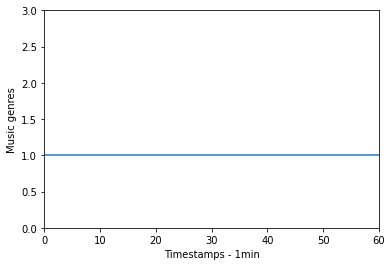

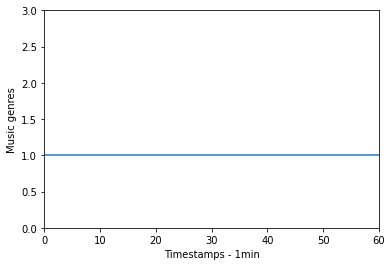

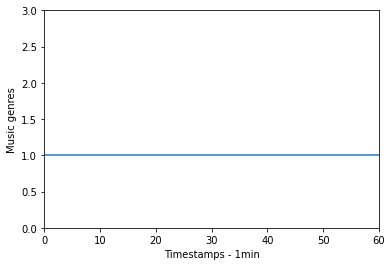

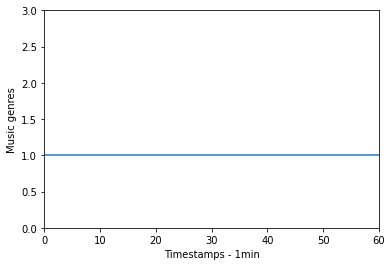

In [ ]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.ylim(0,3)
plt.xlim(0,60)
plt.ylabel("Music genres")
plt.xlabel("Timestamps - 1min")
plt.plot(classical_pred)

plt.figure(2)
plt.ylim(0,3)
plt.xlim(0,60)
plt.ylabel("Music genres")
plt.xlabel("Timestamps - 1min")
plt.plot(pop_pred)

plt.figure(3)
plt.ylim(0,3)
plt.xlim(0,60)
plt.ylabel("Music genres")
plt.xlabel("Timestamps - 1min")
plt.plot(rock_pred)

plt.figure(4)
plt.ylim(0,3)
plt.xlim(0,60)
plt.ylabel("Music genres")
plt.xlabel("Timestamps - 1min")
plt.plot(blues_pred)